# Import libraries and packages

In [ ]:
# Install library for hyperparameter optimisation
# !pip install keras-tuner -q

# Import libraries and packages
import pandas as pd
import numpy as np
import pickle
import itertools
import re
import random
import math
import time
from ast import literal_eval
from collections import Counter
from pprint import pprint
from tqdm import tqdm
import multiprocessing
import os, shutil, sys
from pathlib import Path
from glob import glob
from google.colab.patches import cv2_imshow

# Import libraries and packages for processing images
import cv2
import PIL
from skimage import exposure
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from skimage.exposure import is_low_contrast
import skimage.filters as filters
from skimage.feature import local_binary_pattern
from scipy.stats import mode, norm

from progressbar import ProgressBar, Bar, SimpleProgress
from PIL import Image
from PIL import ImageFile
from IPython.display import Image, clear_output
from scipy import ndimage
from skimage.feature import local_binary_pattern
from skimage.feature import hog
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score, GridSearchCV, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import (confusion_matrix, r2_score, recall_score,
                             precision_score, f1_score, accuracy_score)
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
%matplotlib inline

# Import tensorflow packages and modules
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, BatchNormalization, Lambda,
                                     Concatenate, Activation, Dropout, Flatten, Rescaling,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import keras_tuner
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.utils import (to_categorical, plot_model,
                                    array_to_img, img_to_array, load_img)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        LearningRateScheduler, CSVLogger, ModelCheckpoint,
                                        TensorBoard)
from tensorboard import notebook

# Import library for image augmentation
import imgaug
from imgaug import augmenters as iaa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Save requirements as text file for reproducibility
# !pip freeze > requirements.txt

In [ ]:
# Find out TensorFlow version you are working on
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


# Set Seed

In [ ]:
# Set seed for reproducibility in different runtimes
SEED = 42

# (Optional) Import Google Drive Directory if running this notebook on Google Colaboratory

In [ ]:
# Load Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Replace with your designated working directory
%cd /content/drive/MyDrive/uploaded_datasets/

/content/drive/MyDrive/uploaded_datasets


In [ ]:
# Root directory containing project folders and files; replace with your desired path
DATASET_DIR = os.path.join(os.getcwd(), "pill-classification")
# Dataset Directory (original images)
IMAGE_DIR = os.path.join(DATASET_DIR, "classed_dataset")

# Exploratory Data Analysis

In [ ]:
# Read directory of filepaths and relevant groundtruths from derived Pillbox CSV file
directory_df = pd.read_csv(os.path.join(DATASET_DIR, 'original_directory.csv'),
                           index_col=0,
                           dtype={
                              'ndc': str,
                              'ndc9': str
                              })
directory_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5449 entries, 0 to 5448
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ndc9           5449 non-null   object
 1   filename       5449 non-null   object
 2   is_ref         5449 non-null   bool  
 3   is_front       5449 non-null   bool  
 4   ndc            5449 non-null   object
 5   splshape       5449 non-null   object
 6   splshape_text  5449 non-null   object
 7   splimprint     5442 non-null   object
 8   splcolor_text  5449 non-null   object
 9   rxstring       4881 non-null   object
 10  filepath       5449 non-null   object
dtypes: bool(2), object(9)
memory usage: 436.3+ KB


Replace *filepath* to your desired path

In [ ]:
# Replace path to images
directory_df['filepath'] = [os.path.join(IMAGE_DIR,  # your directory containing dataset
                                    filepath.split('/')[-2],  # folder representing class
                                    filepath.split('/')[-1]) for filepath in directory_df['filepath'].values # filename
                       ]

## Image Samples

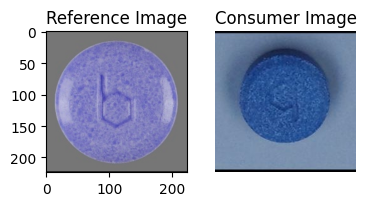

In [ ]:
# Plot samples of reference and consumer images
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(cv2.imread(directory_df[(directory_df['ndc9'] == '512850083') & (directory_df['is_front'] == True) & (directory_df['is_ref'] == True)].filepath.values[0]))
ax[0].set_title("Reference Image")

ax[1].imshow(cv2.imread(directory_df[(directory_df['ndc9'] == '512850083') & (directory_df['is_front'] == True) & (directory_df['is_ref'] == False)].filepath.values[0]))
ax[1].set_title("Consumer Image")

plt.axis('off')
plt.show()

## Data Sample Distribution

In [ ]:
# Get class distribution values
class_distrib = directory_df.ndc9.value_counts().to_dict()
class_names = class_distrib.keys()

In [ ]:
# Plot to visualise data distribution across full dataset
fig = px.histogram(directory_df,
                   x="ndc9",
                   title="Class Distribution")
fig.show()

![Alt text](https://github.com/soyNstacks/pill-image-fusion-classifier/blob/main/image.png?raw=1)

In [ ]:
print("Number of classes: ", len(list(class_distrib.keys())))
print("Total number of samples in dataset: ", len((directory_df)))

Number of classes:  851
Total number of samples in dataset:  5449


## Issue: Sparse dataset and class imbalance

To refine our problem space and minimise predictive errors during the building of a model, we seek to first reduce the dataset by retaining 40 classes that contain the highest number of sample images. Thereafter, we can consider assigning class weights and artificially increasing the number of samples.

In [ ]:
# Plot and visualise distribution of samples in top 40 classes
fig = px.pie(
    names=list(class_names)[:40],
    values=list(class_distrib.values())[:40],
    width=600,
    hole=.3,
    title="Class Distribution"
)
fig.update_layout({'title':{'x': .45}})
fig.show()

![Alt text](https://github.com/soyNstacks/pill-image-fusion-classifier/blob/main/image-1.png?raw=1)

In [ ]:
# Retain 40 classes containing highest number of samples
data_df = directory_df[directory_df['ndc9'].isin(list(class_names)[:40])].reset_index(drop=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ndc9           556 non-null    object
 1   filename       556 non-null    object
 2   is_ref         556 non-null    bool  
 3   is_front       556 non-null    bool  
 4   ndc            556 non-null    object
 5   splshape       556 non-null    object
 6   splshape_text  556 non-null    object
 7   splimprint     556 non-null    object
 8   splcolor_text  556 non-null    object
 9   rxstring       556 non-null    object
 10  filepath       556 non-null    object
dtypes: bool(2), object(9)
memory usage: 40.3+ KB


In [ ]:
data_df.head(5)

,ndc9,filename,is_ref,is_front,ndc,splshape,splshape_text,splimprint,splcolor_text,rxstring,filepath
0,512850083,51285-0083-70_PART_1_OF_2_CHAL10_SB_2E2F970C.jpg,True,False,51285008370,C48348,ROUND,b;247,BROWN,{21 (Ethinyl Estradiol 0.03 MG / norethindrone...,/content/drive/MyDrive/uploaded_datasets/pill-...
1,512850083,51285-0083-70_PART_1_OF_2_CHAL10_SF_2E2F970C.jpg,True,True,51285008370,C48348,ROUND,b;247,BROWN,{21 (Ethinyl Estradiol 0.03 MG / norethindrone...,/content/drive/MyDrive/uploaded_datasets/pill-...
2,512850083,51285-0083-70_PART_2_OF_2_CHAL10_SF_322F991C.jpg,True,True,51285008370,C48348,ROUND,b;247,BROWN,{21 (Ethinyl Estradiol 0.03 MG / norethindrone...,/content/drive/MyDrive/uploaded_datasets/pill-...
3,512850083,51285-0083-70_PART_2_OF_2_CHAL10_SB_322F991C.jpg,True,False,51285008370,C48348,ROUND,b;247,BROWN,{21 (Ethinyl Estradiol 0.03 MG / norethindrone...,/content/drive/MyDrive/uploaded_datasets/pill-...
4,931063,00093-1063-01_PART_1_OF_1_CHAL10_SB_22269114.jpg,True,False,93106301,C48345,OVAL,93;63,BLUE,sotalol hydrochloride 240 MG Oral Tablet,/content/drive/MyDrive/uploaded_datasets/pill-...


In [ ]:
# Define classes as unique NDC9 values
CLASSES = np.unique(data_df["ndc9"].values)
# Define number of classes
NUM_CLASSES = len(CLASSES)

print("Number of classes in new dataset: ", NUM_CLASSES)

Number of classes in new dataset:  40


# Splitting the Dataset

Due to the imbalanced number of samples in each class, the stratified split method was utilised to preserve the original proportion of samples in each class.

To minimise biasness in the dataset, different class weights were assigned to both majority and minority classes. In laymen terms, this means that higher class weights were set for the minority class, while lowered weights were given to the other.

In [ ]:
# Define ratio of splits
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

In [ ]:
# Define X and y variables

# Assign image file paths to X
X = data_df['filepath'].values
# Convert NDC9 strings to unique numerical categories
y_cat = data_df['ndc9'].astype('category').cat.codes.values
# Then convert to one-hot-encoded values
y = to_categorical(y_cat, num_classes=NUM_CLASSES, dtype='float32')

# Observe shapes of X and y
print(X.shape)
print(y.shape)

(556,)
(556, 40)


In [ ]:
# Split dataset into train, test, and validaton sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT,
                                                  stratify=y, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VAL_SPLIT,
                                                  stratify=y_train, random_state=SEED)

# Feature Engineering Functions

## Overview

Applying image pre-processing techniques to enhance colours, and extracting HOG-LBP feature vectors for more meaningful feature represenation and learning.

1. Colour Stream (RGB Images)
2. Shape and Texture (HOG-LBP Feature Vectors)

*   `class ColourPreprocessor(object)`
*   `class TextureDescriptor(object)`



## Colour: Image Preprocessing



> Initial experimentation involved both image preprocessing and obtaining region-based colour histograms as features.

> Region-based colour histograms is a common technique seen in CBIR. In the space of deep learning however, neural networks have the ability to extract high-level features and having images in RGB colour space as inputs to pre-trained models may suffice. The CNN model is likely inclined to learn that certain colours are decisive features as pills of each class contain dominant RGB values that represent colour attributes.

> To sum it up, the colour stream requires image preprocessing techniques:
- Guassian blur to reduce color inconsistencies
- Aadaptive histogram equalisation through LAB colour space + Bilateral filter to smoothen surfaces on the image while still retaining sharp edges.





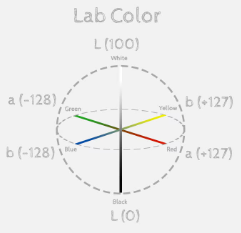


> Source: https://www.photoshopbuzz.com/what-is-lab-color-photoshop/






In [ ]:
class ColourPreprocessor(object):
  """
  Preproccesses dataset of images for colour enhancement
  """

  def __init__(self, target_size=224, clip_limit=3.0, tile_grid_size=(5, 5)):

    # Initialise and assign variables
    self.target_size = target_size
    self.clip_limit = clip_limit
    self.tile_grid_size = tile_grid_size

  def image_generator(self, img):
    """
    Generates preprocessed image
    """
    try:
      # Preprocess image
      pp_img = self.preprocess_image(img)

      return pp_img

    except Exception as e:
      print("[Image generator] Error occured:\n", e)

  def preprocess_image(self, img):
    """
    Function that calls and applies all image preprocessing techniques
    """
    try:
      # Apply blurring to reduce color inconsistencies
      img = cv2.GaussianBlur(img, (3, 3), 0)

      # Apply histogram equalisation
      img = self.hist_equalisation(img)

      return img

    except Exception as e:
      print("[Image preprocessing] Error occured:\n", e)

  def hist_equalisation(self, img):
    """
    Function to apply histogram equalisation technique to L channel of LAB image
    """
    try:
      # Convert image to LAB
      lab_img  = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

      # split the image into L, A, B channels
      l_channel, a_channel, b_channel = cv2.split(lab_img)

      # Apply filter to smoothen image
      lab_img = cv2.bilateralFilter(lab_img, 7 , 11, 11)

      # Apply histogram equalisation technique on lightness (L) channel
      clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
      clahed_l = clahe.apply(l_channel)

      # Merge clahed_l with the remaining untouched A, B channels
      merged_channels = cv2.merge((clahed_l, a_channel, b_channel))

      # Convert back to BGR image
      final_output = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)

      # Return final processed image
      return final_output

    except Exception as e:
      print("[Histogram equalisation] Error occured:\n", e)

## Texture Descriptor: Handcrafted HOG-LBP features


Local Binary Pattern (LBP) is widely used in texture analysis to generate more intricate texture-based features. The LBP algorithm computes a new pixel value by comparing the neighbours of each pixel with its center pixel as a threshold, where the sequence of binary values form the new final pixel in decimal form.

Features of LBP were transformed into a feature histogram to efficiently represent textural properties of both the shape and imprint text regions in each image.

To further improve feature engineering, the integration of Histogram of Oriented Gradients (HOG) was introduced as a descriptor for object localisation. It is a technique that counts events of gradient orientation in specific regions of an image.

These two methods have been long-standing techniques used in facial recogntion models for its effectiveness in detecting key facial structures, in consideration of variations in illumination and occlusions.

In traditional machine learning approaches, feature selection was a subsequent step for removing irrelevant features and reduce dimensionality to prevent overfitting and improve prediction power. For instance, a common technique with Principle Component Analysis (PCA) summarises important information by transforming data into fewer dimensions. In deep learning models, dimensionality reduction methods could aid in reducing the size of the neural network and overfitting issues. However, performance may deteriorate if discriminative features that distinguises classes are of low variance. In addition, overfitting could be minimised through regularisation methods such as Dropout layers. As a result, dimensionality reduction may be deemed unecessary in this case to deter loss of information.

Combined, the LBP histogram and HOG feature vectors becomes a single array for each image to be fed as numerical input into a fusion model.

In [ ]:
class TextureDescriptor(object):
  """
  Preproccesses original dataset of images and extracts feature vectors for texture
  """

  def __init__(self, target_size=224):
    # Initialise and assign variables
    self.target_size = target_size

  def get_combined_features(self, img):
    """|
    Generates combined feature array
    """
    try:
      # Preprocess image
      pp_img = self.preprocess_image(img)

      # Get feature vector from lbp_extractor
      lbp_features = self.lbp_extractor(pp_img)
      # Get feature vector from hog_extractor
      hog_features = self.hog_extractor(pp_img)

      return np.hstack([lbp_features, hog_features])

    except Exception as e:
      print("[Combined feature generator] Error occured:\n", e)


  def resize_img(self, img):
    """
    Resizes image to target size
    """
    try:
      # Source: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
      # (h, w) of original image
      og_size = img.shape[:2]
      # Find ratio to prevent distortion
      ratio = float(self.target_size)/max(og_size)
      # Ratio-ed (h, w) of desired size
      new_size = tuple([int(x*ratio) for x in og_size])
      # (w, h) of target resized image
      img = cv2.resize(img, (new_size[1], new_size[0]))
      # Find differences of desired size (512) and newly computed size
      delta_w = self.target_size - new_size[1]
      delta_h = self.target_size - new_size[0]
      # Compute values for image padding to make black borders
      top, bottom = delta_h//2, delta_h-(delta_h//2)
      left, right = delta_w//2, delta_w-(delta_w//2)
      # Generate final binary image according to target size
      final_img = cv2.copyMakeBorder(img, top, bottom, left, right,
                                    cv2.BORDER_CONSTANT,
                                    value=[0, 0, 0])

      return final_img

    except Exception as e:
      print("[Image resizing] Error occured:\n", e)

  def lbp_extractor(self, img):
    """
    Returns derived LBP bins as array
    """
    # Define values for lbp
    radius= 2
    num_pts = 10
    bin = 2**num_pts

    # Compute lbp
    lbp = local_binary_pattern(img, num_pts, radius, method='uniform')
    # Compute lbp histograms by bins
    (hist, hist_len) = np.histogram(lbp.ravel(), bins=np.arange(0, bin))
    lbp_hist = hist.astype("float32")

    # Return array in float32 format
    return np.array(lbp_hist, np.float32)

  def hog_extractor(self, img):
    """
    Returns derived HOG array
    """
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True, channel_axis=None)

    # Rescale histogram for better intensity
    fd = exposure.rescale_intensity(fd, in_range=(0, 10))

    # Return array in float32 format
    return np.array(fd, np.float32)

  def preprocess_image(self, img):
    """
    Image preprocessing before extracting shape and textural features
    """
    try:
      # Make sure all images have the same size
      img = self.resize_img(img)

      # Convert image to greyscale
      grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Apply gaussian filter
      gaussian = cv2.GaussianBlur(grey_img, (3, 3) ,cv2.BORDER_DEFAULT)

      return grey_img

    except Exception as e:
      print("[Image Preprocessing] Error occured:\n", e)

# Building and Training Deep Learning Model

# (1) Baseline CNN Model

The formation of the baseline model adopts a basic image data generator with TensorFlow' built-in methods, followed by the building and training of a simple CNN model. To aid readability of the multi-stepped  implementation in this notebook, please refer to the notebook titled 'experiment_model-development.ipynb'.


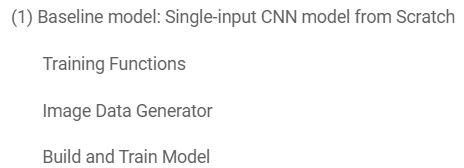

In [ ]:
# Load baseline CNN model trained in separate notebook
baseline_cnn_model = load_model("/content/drive/MyDrive/uploaded_datasets/pill-recognition/all-results/baseline-results-cnn/Single_Baseline_PP/Single_Baseline_PP_coloured_base_v1")

# Print model summary
print(baseline_cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

# (2) Single-input Transfer Learning Model

The formation of the baseline model adopts a basic image data generator with TensorFlow' built-in methods, followed by the building and training of a simple CNN model. To aid readability of the multi-stepped  implementation in this notebook, please refer to the notebook titled 'experiment_model-development.ipynb'.

Transfer learning models compared:

*   MobileNet V2 ('MobileNet')
*   ResNet-50 V2 ('ResNet-50')

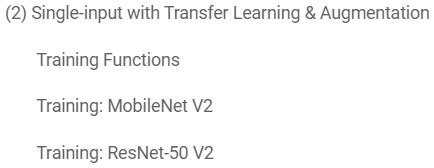

## 2.1 MobileNet


In [ ]:
# Load single input MobileNet model trained in separate notebook
mobilenet_single_pp_model = load_model("/content/drive/MyDrive/uploaded_datasets/pill-recognition/all-results/single-results-pp/MobileNet_Single_PP/MobileNet_Single_PP_v1")

# Print model summary
print(mobilenet_single_pp_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 coloured_image (InputLayer  [(None, 224, 224, 3)]     0         
 )                                                               
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0     

## 2.2 ResNet-50

In [ ]:
# Load single input ResNet-50 model trained in separate notebook
resnet_single_pp_model = load_model("/content/drive/MyDrive/uploaded_datasets/pill-recognition/all-results/single-results-pp/ResNet50_Single_PP/ResNet50_Single_PP_v1")

# Print model summary
print(resnet_single_pp_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 coloured_image (InputLayer  [(None, 224, 224, 3)]     0         
 )                                                               
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                 

# Common Training Functions for Fusion Model

## Overview
- `get_class_weights`: Computes class weights for sample balance
- `add_callbacks`: Adds callbacks to customise behaviour of model
- `compile_model`: Compiles model
- `save_model_archi`: Saves model architecture as image with filename and model as inputs


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

Load Tensorboard

In [ ]:
# Load tensorboard to visualise model performance
%load_ext tensorboard

In [ ]:
def get_class_weights(y_train, is_encoded=False):
  """
  Computes class weights to resolve imbalanced dataset
  """

  #Cconvert from np.array of one-hot encoded labels to integers
  if is_encoded:
    y_train_encoded = y_train
    y_train = [np.argmax(lbl) for lbl in y_train_encoded]

  # Compute class weights
  class_weights = class_weight.compute_class_weight(
      'balanced', classes=np.unique(y_train), y=y_train)

  # Assign weights for model
  class_weights_dict = dict(enumerate(class_weights))

  return class_weights_dict

def save_model_archi(model, filename):
  tf.keras.utils.plot_model(
      model,
      to_file="/content/{}.png".format(filename),
      show_shapes=True,
      show_layer_names=True,
      show_layer_activations=True
  )

  print(f"Saved to {filename}")

def add_callbacks(patience=5):
  """
  Returns additional callbacks for model,
  arg: patience value
  """
  lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                                mode="min",
                                factor=0.2,
                                patience=patience, verbose=1),
  early_stopping = EarlyStopping(monitor="val_loss", mode="min",
                                 patience=patience, restore_best_weights=True)

  return [lr_reduce, early_stopping]

def compile_model(model,
                  optimizer,
                  loss='categorical_crossentropy'):
    """
    Compiles a model with selected metrics,
    args: optimizer, loss
    """
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_k_categorical_accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.FalsePositives(name='false_positives')
        ]
    )

    return model

In [ ]:
def plot_training_history(history):
  '''
  Plots the training history
  '''

  # 'loss', 'accuracy', 'top_k_categorical_accuracy', 'precision', 'recall', 'false_positives'
  fig, axs = plt.subplots(3, 2, figsize=(15, 12))
  fig.suptitle('Training History')
  axs[0, 0].plot(history.history['accuracy'])
  axs[0, 0].plot(history.history['val_accuracy'])
  axs[0, 0].set_title('Accuracy')
  axs[0, 0].set_ylabel('Accuracy')
  # axs[0, 0].set_xlabel('Epoch')
  axs[0, 0].legend(['Train', 'Validation'], loc='upper left')

  axs[0, 1].plot(history.history['loss'])
  axs[0, 1].plot(history.history['val_loss'])
  axs[0, 1].set_title('Loss')
  axs[0, 1].set_ylabel('Loss')
  # axs[0, 1].set_xlabel('Epoch')
  axs[0, 1].legend(['Train', 'Validation'], loc='upper left')

  axs[1, 0].plot(history.history['top_k_categorical_accuracy'])
  axs[1, 0].plot(history.history['val_top_k_categorical_accuracy'])
  axs[1, 0].set_title('Top K Accuracy')
  axs[1, 0].set_ylabel('Top K Accuracy')
  # axs[1, 0].set_xlabel('Epoch')
  axs[1, 0].legend(['Train', 'Validation'], loc='upper left')

  axs[1, 1].plot(history.history['precision'])
  axs[1, 1].plot(history.history['val_precision'])
  axs[1, 1].set_title('Precision')
  axs[1, 1].set_ylabel('Precision')
  # axs[1, 1].set_xlabel('Epoch')
  axs[1, 1].legend(['Train', 'Validation'], loc='upper left')

  axs[2, 0].plot(history.history['recall'])
  axs[2, 0].plot(history.history['val_recall'])
  axs[2, 0].set_title('Recall')
  axs[2, 0].set_ylabel('Recall')
  axs[2, 0].set_xlabel('Epoch')
  axs[2, 0].legend(['Train', 'Validation'], loc='upper left')

  axs[2, 1].plot(history.history['false_positives'])
  axs[2, 1].plot(history.history['val_false_positives'])
  axs[2, 1].set_title('False Positives')
  axs[2, 1].set_ylabel('False Positives')
  axs[2, 1].set_xlabel('Epoch')
  axs[2, 1].legend(['Train', 'Validation'], loc='upper left')

  plt.show()

## Custom Image DataGenerator

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):

  def __init__(self,
              data_dict,
              batch_size=BATCH_SIZE, num_classes=NUM_CLASSES,
              image_dim=(IMAGE_SIZE, IMAGE_SIZE),
              clip_limit=3.0,tile_grid_size=(5, 5),
              is_train=True, is_shuffle=False, is_augment=False):

    """
    Custom data generator that gives ([image array, feature vectors], label) as output

    Args:
    data_dict: { [keys=image file path]: [value=label]}
    ---> image file path: path to images (string)
    ---> label: one hot encoded y categorical values (numpy array)

    is_train: True if input data is a train set
    is_shuffle: True to shuffle input data and if it is a train set
    is_augment: True to perform data augmentation and if it is a train set

    note: output of feature_vectors is the LBP-HOG feature vector (numpy array)
    """

    # Define variables
    self.image_filepaths = list(data_dict.keys())
    self.labels = data_dict

    self.image_dim = image_dim
    self.batch_size = batch_size
    self.num_classes = num_classes
    self.class_indices = dict(zip(range(len(list(data_dict.values()))), list(data_dict.values())))

    self.is_train = is_train
    self.is_augment = is_augment
    self.is_shuffle = is_shuffle
    self.indices = np.arange(len(list(data_dict.keys())))

    # Instantiate class instance
    self.colour_preprocessor = ColourPreprocessor(target_size=self.image_dim[0],
                                            clip_limit=clip_limit,
                                            tile_grid_size=tile_grid_size)
    # Instantiate class instance
    self.texture_extractor = TextureDescriptor(target_size=self.image_dim[0])


    # Prevent shuffling and augmentation for
    ## generation of validation or test set
    if is_train == False:
        self.is_shuffle = False
        self.is_augment = False

    if self.is_train:
        self.on_epoch_end()

    # Define augmentations to perform on images
    self.iaa_augs = iaa.Sequential(
        [
            # Rotate the Images
            iaa.Affine(rotate=(-15, 15)),
            # Scale the Images
            iaa.Affine(scale=(0.5, 1.5)),
            # Flip the Images
            iaa.Fliplr(0.5),
            # Apply guassian filter to only 50% of all images
            iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
            # Multiply all pixels with a specific value
            iaa.Multiply((0.8, 1.5)),
        ]
    )

    print(f"Found {len(self.image_filepaths)} images belonging to {self.num_classes} classes")

  def __len__(self):
    """
    Returns number of input data per batch
    """
    return int(np.floor(len(self.image_filepaths) / self.batch_size))

  def __getitem__(self, idx):
    """
    Generates a batch of data in the form of X, y
    """
    # Get indices of the batch
    indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

    # Get list of IDs
    img_files_temp = [self.image_filepaths[i] for i in indices]

    # Generate data
    X, y = self.__data_generate(img_files_temp)

    return X, y

  def next(self):
    return self.__next__()

  def on_epoch_end(self):
    """
    Shuffle batch of data at every epoch
    """
    self.indices = np.arange(len(self.image_filepaths))
    if(self.is_train):
      np.random.shuffle(self.indices)
    else:
      pass

  def shuffle_data(self, x, y):
    """
    Shuffle data set

    x: a list of two numpy arrays [images, vectors],
    where images = x[0], vectors=x[1],
    images and vectors each is an array of size = self.batch_size
    """
    lam = np.random.beta(0.2, 0.4)
    ori_index = np.arange(int(len(x[0])))
    index_array = np.arange(int(len(x[0])))
    np.random.shuffle(index_array)

    shuffled_x = [lam * x[0][ori_index] + (1 - lam) * x[0][index_array],
                  lam * x[1][ori_index] + (1 - lam) * x[1][index_array]]
    shuffled_y = lam * y[ori_index] + (1 - lam) * y[index_array]

    return shuffled_x, shuffled_y

  def __data_generate(self, img_files_temp):
    """
    Generates batches of data
    """
    X_img = []
    X_features = []
    y = [0] * self.batch_size

    # Generate data
    for i, img_file in enumerate(img_files_temp):
      # Read image
      img = cv2.imread(img_file)

      # Generate preprocessed image and apply image augmentation
      if self.is_augment:
          img = self.iaa_augs.augment_image(img)

      # Generate feature vector on preprocessed image
      lbp_hog = self.texture_extractor.get_combined_features(img)

      X_img.append(img)
      X_features.append(lbp_hog)
      y[i] = self.labels[img_file]

    X = [np.array(X_img, np.float32), np.array(X_features, np.float32)]
    y = np.asarray(y, dtype=np.float32)
    # y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)

    if self.is_shuffle:
        X, y = self.shuffle_data(X, y)

    return X, y

### Input for CustomDataGenerator

In [ ]:
def get_data_dict(X_image_paths, y):
  """
  Returns a dictionary of
  - key: image file path,
  - value: corresponding one-hot-encoded y label
  """
  # Create empty dictionary for storage
  output_dict = dict()

  for image_path, label in zip(X_image_paths, y):
    # Assign y label to image file path
    output_dict[image_path] = label

  # Return final output dictionary
  return output_dict

In [ ]:
# Generate dictionaries for test, validation, and test sets
train_data_dict = get_data_dict(X_train, y_train)
val_data_dict = get_data_dict(X_val, y_val)
test_data_dict = get_data_dict(X_test, y_test)

print(len(train_data_dict))
print(len(val_data_dict))
print(len(test_data_dict))

400
100
56


In [ ]:
# Initialise data generator for train set with augmentation and shuffling of data
custom_train_datagen = CustomDataGenerator(data_dict=train_data_dict,
                                           is_train=True, is_augment=True, is_shuffle=True)

# Initialise data generator for validation set
custom_val_datagen = CustomDataGenerator(data_dict=val_data_dict,
                                         is_train=False, is_augment=False, is_shuffle=False)

Found 400 images belonging to 40 classes
Found 100 images belonging to 40 classes


## Compute Classweights

In [ ]:
# Initialise computation fo class weights
class_weights = get_class_weights(list(train_data_dict.values()), is_encoded=True)

In [ ]:
class_weights

{0: 1.1111111111111112,
 1: 1.0,
 2: 1.1111111111111112,
 3: 1.0,
 4: 1.0,
 5: 1.1111111111111112,
 6: 1.1111111111111112,
 7: 1.0,
 8: 1.0,
 9: 1.1111111111111112,
 10: 1.1111111111111112,
 11: 1.0,
 12: 1.1111111111111112,
 13: 1.1111111111111112,
 14: 0.9090909090909091,
 15: 1.1111111111111112,
 16: 0.5882352941176471,
 17: 1.0,
 18: 1.0,
 19: 0.625,
 20: 1.0,
 21: 1.0,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 1.1111111111111112,
 27: 1.0,
 28: 1.1111111111111112,
 29: 1.0,
 30: 1.0,
 31: 1.1111111111111112,
 32: 1.1111111111111112,
 33: 1.0,
 34: 1.0,
 35: 1.0,
 36: 1.1111111111111112,
 37: 1.0,
 38: 1.0,
 39: 1.0}

# (3) Multi-input, Mixed-data Fusion Model with Transfer Learning

A 'two-shot' approach with:
1. Preprocessed image for Colour stream
2. Feature vector for Texture stream

## Functions to Build Fusion Model

In [ ]:
def create_folder(base_dir, folder_name):
  """
  Creates a folder in designated directory and returns relative path
  """
  new_path = os.path.join(base_dir, folder_name)
  try:
    os.makedirs(new_path)
  except FileExistsError:
    print('Folder exists')

  return new_path

In [ ]:
def build_colour_cnn(base_model, model_name, is_trainable,
                     drop_out=0.25,
                     img_size=IMAGE_SIZE):

  """
  Builds and returns CNN model with pre-trained weights for Colour stream
  """

  print("Backbone model: ", model_name)

  # Define inputs
  input_image = Input(shape=(img_size, img_size, 3), name="coloured_image")

  # Freeze convolutional base
  if is_trainable == False:
    base_model.trainable = False

  # Instantiate pre-trained model
  if 'MobileNet' in model_name:
    # Pre-process input for model
    x = Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)(input_image)

  # Instantiate pre-trained model
  elif 'ResNet50' in model_name:
    # Pre-process input for model
    x = Lambda(tf.keras.applications.resnet_v2.preprocess_input)(input_image)

  else:
    print('Backbone model not found')

  x = base_model(x, training=False)
  # Create fully connected layers
  x = GlobalAveragePooling2D()(x)
  # Add a Dropout layer
  x = Dropout(drop_out)(x)
  # Add Dense layers
  x = Dense(128, activation='relu')(x)
  # Add a Dropout layer
  x = Dropout(drop_out)(x)
  x = Dense(64, activation='relu')(x)

  # Create CNN model
  x = Model(inputs=input_image, outputs=x)

  return x


def build_texture_dnn():
  """
  Builds and returns feed-forward model for Texture stream
  """

  # Define inputs
  input_texture = Input(shape=(27267,), name="texture_vector")

  y = Dense(64, activation='relu')(input_texture)
  y = Dense(28, activation='relu')(y)
  y = Dense(8, activation='relu')(y)
  y = Model(inputs=input_texture, outputs=y)

  return y

def build_fusion_model(base_model, model_name, is_trainable,
                       cnn_drop_out=0.25,
                       num_classes=NUM_CLASSES,
                       img_size=IMAGE_SIZE):

  """
  Builds fusion CNN-MLP model for mixed-data inputs and multi-output
  """

  # Instantiate model for Colour Stream
  x = build_colour_cnn(base_model, model_name, is_trainable,
                   drop_out=cnn_drop_out,
                   img_size=IMAGE_SIZE)

  # Instantiate model for Texture Stream
  y = build_texture_dnn()

  # Concatenate two streams together
  combined = layers.concatenate([x.output, y.output])

  # Define joined Layer
  z = Dense(64, activation="relu")(combined)

  # Add Dense layer to output predictions
  z = Dense(num_classes, activation='softmax', name='predictions')(z)

  # Define the final model
  model = Model(inputs=[x.input, y.input], outputs=z)

  # Print model summary
  print(model.summary())

  return model

def train_fusion_model(
  model, model_name,
  train_gen, val_gen,
  batch_size,
  class_weights,
  result_dir,
  log_dir,
  version,
  workers, use_multiprocessing,
  initial_epoch=0, epochs=20,
  initial_value_threshold=None,
  additional_callbacks=[]):
  """
  Trains fusion model with inputs from custom data generator (CustomDataGenerator)
  """

  if not os.path.exists(os.path.join(result_dir, model_name)):
      os.makedirs(os.path.join(result_dir, model_name))

  if not os.path.exists(os.path.join(log_dir, model_name)):
      os.makedirs(os.path.join(log_dir, model_name))

  model_log_dir = os.path.join(log_dir, model_name, f'{model_name}_{version}')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(model_log_dir, histogram_freq=1)

  start_time = time.perf_counter()

  history = model.fit(
      train_gen,
      validation_data=val_gen,
      class_weight=class_weights,
      epochs=epochs,
      initial_epoch=initial_epoch,
      workers=workers,
      use_multiprocessing=use_multiprocessing,
      verbose=1,
      callbacks=[
          tensorboard_callback,
          tf.keras.callbacks.TerminateOnNaN(),
          tf.keras.callbacks.CSVLogger(os.path.join(result_dir, model_name, f'{model_name}_{version}.log'), separator=',', append=True),
          tf.keras.callbacks.ModelCheckpoint(os.path.join(result_dir, model_name, f'{model_name}_{version}'),
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='min', initial_value_threshold=initial_value_threshold)
      ] + additional_callbacks
  )

  elapsed_time = time.perf_counter() - start_time

  return history, model, elapsed_time

In [ ]:
# Create root folder to store all model outcomes
ROOT_RESULT_DIR = create_folder(DATASET_DIR, 'all-results')
# Create folder to store outcomes for section 3 models
# Directories to store multi-input pre-trained results
PP_MULTI_RESULT_DIR = create_folder(ROOT_RESULT_DIR, 'multi-results-pp')
PP_MULTI_TB_DIR = create_folder(ROOT_RESULT_DIR, 'multi-tb-pp')

Folder exists
Folder exists
Folder exists


## 3.1.1 Frozen layers with 50 epochs: MobileNet

In [ ]:
# Clear existing sessions if needed
# tf.keras.backend.clear_session()

In [ ]:
model_name = 'MobileNet_Multi'

# Load MobileNet V2 with ImageNet weights without last fully connected layers
mobilenet_base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                      weights='imagenet',
                                      include_top=False)

mobilenet_multi_3 = build_fusion_model(mobilenet_base_model, model_name,
                                       is_trainable=False)

Backbone model:  MobileNet_Multi
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 coloured_image (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['coloured_image[0][0]']         
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['lambda[0][0]']                 
 al)                                                                                              
                                                           

In [ ]:
# Compile model
mobilenet_multi_3 = compile_model(mobilenet_multi_3, optimizer=Adam())

mobilenet_multi_3_history, mobilenet_multi_3, mobilenet_multi_3_elapsed_time = train_fusion_model(
    mobilenet_multi_3, model_name,
    train_gen=custom_train_datagen,
    val_gen=custom_val_datagen,
    class_weights=class_weights,
    result_dir=PP_MULTI_RESULT_DIR,
    log_dir=PP_MULTI_TB_DIR,
    additional_callbacks=add_callbacks(5),
    epochs=50,
    workers=4,
    use_multiprocessing=True,
    version='v3',
    batch_size=BATCH_SIZE)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 10.0470 - accuracy: 0.0234 - top_k_categorical_accuracy: 0.1146 - precision: 0.0388 - recall: 0.0066 - false_positives: 124.0000
Epoch 1: val_loss improved from inf to 3.80144, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 152s 10s/step - loss: 10.0470 - accuracy: 0.0234 - top_k_categorical_accuracy: 0.1146 - precision: 0.0388 - recall: 0.0066 - false_positives: 124.0000 - val_loss: 3.8014 - val_accuracy: 0.0312 - val_top_k_categorical_accuracy: 0.1562 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 3.8145 - accuracy: 0.0365 - top_k_categorical_accuracy: 0.1432 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 2: val_loss improved from 3.80144 to 3.62966, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 3.8145 - accuracy: 0.0365 - top_k_categorical_accuracy: 0.1432 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.6297 - val_accuracy: 0.0104 - val_top_k_categorical_accuracy: 0.2292 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 3.6676 - accuracy: 0.0443 - top_k_categorical_accuracy: 0.2031 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 3: val_loss improved from 3.62966 to 3.57690, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 3.6676 - accuracy: 0.0443 - top_k_categorical_accuracy: 0.2031 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.5769 - val_accuracy: 0.0417 - val_top_k_categorical_accuracy: 0.2292 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 3.5795 - accuracy: 0.0521 - top_k_categorical_accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 4: val_loss improved from 3.57690 to 3.49817, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 3.5795 - accuracy: 0.0521 - top_k_categorical_accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4982 - val_accuracy: 0.1042 - val_top_k_categorical_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 3.5304 - accuracy: 0.0703 - top_k_categorical_accuracy: 0.2943 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 5: val_loss improved from 3.49817 to 3.42105, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 3.5304 - accuracy: 0.0703 - top_k_categorical_accuracy: 0.2943 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4211 - val_accuracy: 0.1250 - val_top_k_categorical_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 6/50
11/12 [==========================>...] - ETA: 0s - loss: 3.4819 - accuracy: 0.0795 - top_k_categorical_accuracy: 0.3210 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 6: val_loss improved from 3.42105 to 3.31157, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 3.4745 - accuracy: 0.0911 - top_k_categorical_accuracy: 0.3359 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.3116 - val_accuracy: 0.1875 - val_top_k_categorical_accuracy: 0.4062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 3.3027 - accuracy: 0.1302 - top_k_categorical_accuracy: 0.3724 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 7: val_loss improved from 3.31157 to 3.13087, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 3.3027 - accuracy: 0.1302 - top_k_categorical_accuracy: 0.3724 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.1309 - val_accuracy: 0.1458 - val_top_k_categorical_accuracy: 0.5104 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 8/50
12/12 [==============================] - ETA: 0s - loss: 3.1413 - accuracy: 0.1823 - top_k_categorical_accuracy: 0.4740 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 8: val_loss improved from 3.13087 to 2.99099, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 3.1413 - accuracy: 0.1823 - top_k_categorical_accuracy: 0.4740 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.9910 - val_accuracy: 0.1667 - val_top_k_categorical_accuracy: 0.4896 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 9/50
12/12 [==============================] - ETA: 0s - loss: 2.9434 - accuracy: 0.1979 - top_k_categorical_accuracy: 0.4974 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000
Epoch 9: val_loss improved from 2.99099 to 2.72035, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 47s 4s/step - loss: 2.9434 - accuracy: 0.1979 - top_k_categorical_accuracy: 0.4974 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000 - val_loss: 2.7204 - val_accuracy: 0.2708 - val_top_k_categorical_accuracy: 0.5625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 10/50
12/12 [==============================] - ETA: 0s - loss: 3.0553 - accuracy: 0.1849 - top_k_categorical_accuracy: 0.4948 - precision: 0.7500 - recall: 0.0040 - false_positives: 1.0000
Epoch 10: val_loss improved from 2.72035 to 2.59023, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 3.0553 - accuracy: 0.1849 - top_k_categorical_accuracy: 0.4948 - precision: 0.7500 - recall: 0.0040 - false_positives: 1.0000 - val_loss: 2.5902 - val_accuracy: 0.3125 - val_top_k_categorical_accuracy: 0.6042 - val_precision: 1.0000 - val_recall: 0.0208 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 11/50
12/12 [==============================] - ETA: 0s - loss: 2.6556 - accuracy: 0.2630 - top_k_categorical_accuracy: 0.6224 - precision: 0.8125 - recall: 0.0173 - false_positives: 3.0000
Epoch 11: val_loss improved from 2.59023 to 2.47388, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 2.6556 - accuracy: 0.2630 - top_k_categorical_accuracy: 0.6224 - precision: 0.8125 - recall: 0.0173 - false_positives: 3.0000 - val_loss: 2.4739 - val_accuracy: 0.3021 - val_top_k_categorical_accuracy: 0.6458 - val_precision: 1.0000 - val_recall: 0.0312 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 12/50
12/12 [==============================] - ETA: 0s - loss: 2.9582 - accuracy: 0.2214 - top_k_categorical_accuracy: 0.5703 - precision: 0.8333 - recall: 0.0202 - false_positives: 3.0000
Epoch 12: val_loss improved from 2.47388 to 2.40856, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 2.9582 - accuracy: 0.2214 - top_k_categorical_accuracy: 0.5703 - precision: 0.8333 - recall: 0.0202 - false_positives: 3.0000 - val_loss: 2.4086 - val_accuracy: 0.3333 - val_top_k_categorical_accuracy: 0.6875 - val_precision: 1.0000 - val_recall: 0.0417 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 13/50
12/12 [==============================] - ETA: 0s - loss: 2.3528 - accuracy: 0.3151 - top_k_categorical_accuracy: 0.6771 - precision: 0.7727 - recall: 0.0228 - false_positives: 5.0000
Epoch 13: val_loss improved from 2.40856 to 2.26622, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 2.3528 - accuracy: 0.3151 - top_k_categorical_accuracy: 0.6771 - precision: 0.7727 - recall: 0.0228 - false_positives: 5.0000 - val_loss: 2.2662 - val_accuracy: 0.3125 - val_top_k_categorical_accuracy: 0.6979 - val_precision: 1.0000 - val_recall: 0.0625 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 14/50
12/12 [==============================] - ETA: 0s - loss: 2.5018 - accuracy: 0.3490 - top_k_categorical_accuracy: 0.6719 - precision: 0.8684 - recall: 0.0445 - false_positives: 5.0000
Epoch 14: val_loss improved from 2.26622 to 2.17180, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 2.5018 - accuracy: 0.3490 - top_k_categorical_accuracy: 0.6719 - precision: 0.8684 - recall: 0.0445 - false_positives: 5.0000 - val_loss: 2.1718 - val_accuracy: 0.3438 - val_top_k_categorical_accuracy: 0.6875 - val_precision: 1.0000 - val_recall: 0.0938 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 15/50
12/12 [==============================] - ETA: 0s - loss: 2.9085 - accuracy: 0.2708 - top_k_categorical_accuracy: 0.5599 - precision: 0.7857 - recall: 0.0294 - false_positives: 6.0000
Epoch 15: val_loss improved from 2.17180 to 2.16886, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 2.9085 - accuracy: 0.2708 - top_k_categorical_accuracy: 0.5599 - precision: 0.7857 - recall: 0.0294 - false_positives: 6.0000 - val_loss: 2.1689 - val_accuracy: 0.3333 - val_top_k_categorical_accuracy: 0.7083 - val_precision: 0.8182 - val_recall: 0.0938 - val_false_positives: 2.0000 - lr: 0.0010
Epoch 16/50
12/12 [==============================] - ETA: 0s - loss: 2.5897 - accuracy: 0.3099 - top_k_categorical_accuracy: 0.6875 - precision: 0.8788 - recall: 0.0385 - false_positives: 4.0000
Epoch 16: val_loss improved from 2.16886 to 2.15979, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 49s 4s/step - loss: 2.5897 - accuracy: 0.3099 - top_k_categorical_accuracy: 0.6875 - precision: 0.8788 - recall: 0.0385 - false_positives: 4.0000 - val_loss: 2.1598 - val_accuracy: 0.3229 - val_top_k_categorical_accuracy: 0.7604 - val_precision: 1.0000 - val_recall: 0.1146 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 17/50
12/12 [==============================] - ETA: 0s - loss: 2.1779 - accuracy: 0.3646 - top_k_categorical_accuracy: 0.7708 - precision: 0.8571 - recall: 0.0480 - false_positives: 6.0000
Epoch 17: val_loss improved from 2.15979 to 2.11245, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 2.1779 - accuracy: 0.3646 - top_k_categorical_accuracy: 0.7708 - precision: 0.8571 - recall: 0.0480 - false_positives: 6.0000 - val_loss: 2.1125 - val_accuracy: 0.3750 - val_top_k_categorical_accuracy: 0.7500 - val_precision: 0.9333 - val_recall: 0.1458 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 18/50
11/12 [==========================>...] - ETA: 0s - loss: 2.6227 - accuracy: 0.3352 - top_k_categorical_accuracy: 0.6449 - precision: 0.9024 - recall: 0.0535 - false_positives: 4.0000
Epoch 18: val_loss improved from 2.11245 to 2.05359, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 2.5895 - accuracy: 0.3281 - top_k_categorical_accuracy: 0.6536 - precision: 0.8333 - recall: 0.0530 - false_positives: 8.0000 - val_loss: 2.0536 - val_accuracy: 0.3646 - val_top_k_categorical_accuracy: 0.7500 - val_precision: 0.9231 - val_recall: 0.1250 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 19/50
12/12 [==============================] - ETA: 0s - loss: 1.9148 - accuracy: 0.4297 - top_k_categorical_accuracy: 0.8073 - precision: 0.7714 - recall: 0.0716 - false_positives: 16.0000
Epoch 19: val_loss improved from 2.05359 to 2.01294, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 50s 4s/step - loss: 1.9148 - accuracy: 0.4297 - top_k_categorical_accuracy: 0.8073 - precision: 0.7714 - recall: 0.0716 - false_positives: 16.0000 - val_loss: 2.0129 - val_accuracy: 0.4167 - val_top_k_categorical_accuracy: 0.7500 - val_precision: 0.8824 - val_recall: 0.1562 - val_false_positives: 2.0000 - lr: 0.0010
Epoch 20/50
12/12 [==============================] - ETA: 0s - loss: 2.1393 - accuracy: 0.4323 - top_k_categorical_accuracy: 0.7865 - precision: 0.7907 - recall: 0.0916 - false_positives: 18.0000
Epoch 20: val_loss improved from 2.01294 to 1.92540, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 49s 4s/step - loss: 2.1393 - accuracy: 0.4323 - top_k_categorical_accuracy: 0.7865 - precision: 0.7907 - recall: 0.0916 - false_positives: 18.0000 - val_loss: 1.9254 - val_accuracy: 0.3333 - val_top_k_categorical_accuracy: 0.7917 - val_precision: 0.7727 - val_recall: 0.1771 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 21/50
12/12 [==============================] - ETA: 0s - loss: 2.6423 - accuracy: 0.3464 - top_k_categorical_accuracy: 0.6927 - precision: 0.8286 - recall: 0.0786 - false_positives: 12.0000
Epoch 21: val_loss did not improve from 1.92540
12/12 [==============================] - 25s 2s/step - loss: 2.6423 - accuracy: 0.3464 - top_k_categorical_accuracy: 0.6927 - precision: 0.8286 - recall: 0.0786 - false_positives: 12.0000 - val_loss: 1.9584 - val_accuracy: 0.4375 - val_top_k_categorical_accuracy: 0.7812 - val_precision: 0.9412 - val_recall: 0.1667 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 22/50
12/12 [===================

12/12 [==============================] - 52s 4s/step - loss: 2.0611 - accuracy: 0.4297 - top_k_categorical_accuracy: 0.8307 - precision: 0.8356 - recall: 0.0804 - false_positives: 12.0000 - val_loss: 1.8091 - val_accuracy: 0.4583 - val_top_k_categorical_accuracy: 0.8229 - val_precision: 0.8000 - val_recall: 0.1667 - val_false_positives: 4.0000 - lr: 0.0010
Epoch 25/50
12/12 [==============================] - ETA: 0s - loss: 2.1786 - accuracy: 0.4323 - top_k_categorical_accuracy: 0.7812 - precision: 0.8866 - recall: 0.1144 - false_positives: 11.0000
Epoch 25: val_loss improved from 1.80907 to 1.78788, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 49s 4s/step - loss: 2.1786 - accuracy: 0.4323 - top_k_categorical_accuracy: 0.7812 - precision: 0.8866 - recall: 0.1144 - false_positives: 11.0000 - val_loss: 1.7879 - val_accuracy: 0.4792 - val_top_k_categorical_accuracy: 0.8021 - val_precision: 0.7917 - val_recall: 0.1979 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 26/50
12/12 [==============================] - ETA: 0s - loss: 1.8580 - accuracy: 0.5208 - top_k_categorical_accuracy: 0.8698 - precision: 0.8246 - recall: 0.1260 - false_positives: 20.0000
Epoch 26: val_loss improved from 1.78788 to 1.75506, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 1.8580 - accuracy: 0.5208 - top_k_categorical_accuracy: 0.8698 - precision: 0.8246 - recall: 0.1260 - false_positives: 20.0000 - val_loss: 1.7551 - val_accuracy: 0.4583 - val_top_k_categorical_accuracy: 0.7917 - val_precision: 0.8636 - val_recall: 0.1979 - val_false_positives: 3.0000 - lr: 0.0010
Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 2.1623 - accuracy: 0.4245 - top_k_categorical_accuracy: 0.8229 - precision: 0.8152 - recall: 0.0991 - false_positives: 17.0000
Epoch 27: val_loss did not improve from 1.75506
12/12 [==============================] - 26s 2s/step - loss: 2.1623 - accuracy: 0.4245 - top_k_categorical_accuracy: 0.8229 - precision: 0.8152 - recall: 0.0991 - false_positives: 17.0000 - val_loss: 1.7934 - val_accuracy: 0.4792 - val_top_k_categorical_accuracy: 0.8229 - val_precision: 0.8148 - val_recall: 0.2292 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 28/50
12/12 [===================

12/12 [==============================] - 52s 4s/step - loss: 2.3834 - accuracy: 0.4115 - top_k_categorical_accuracy: 0.7526 - precision: 0.9125 - recall: 0.1006 - false_positives: 7.0000 - val_loss: 1.7109 - val_accuracy: 0.4792 - val_top_k_categorical_accuracy: 0.8021 - val_precision: 0.8077 - val_recall: 0.2188 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 30/50
12/12 [==============================] - ETA: 0s - loss: 1.6691 - accuracy: 0.5755 - top_k_categorical_accuracy: 0.8776 - precision: 0.8772 - recall: 0.1361 - false_positives: 14.0000
Epoch 30: val_loss improved from 1.71090 to 1.67401, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 49s 4s/step - loss: 1.6691 - accuracy: 0.5755 - top_k_categorical_accuracy: 0.8776 - precision: 0.8772 - recall: 0.1361 - false_positives: 14.0000 - val_loss: 1.6740 - val_accuracy: 0.4792 - val_top_k_categorical_accuracy: 0.8229 - val_precision: 0.7419 - val_recall: 0.2396 - val_false_positives: 8.0000 - lr: 0.0010
Epoch 31/50
12/12 [==============================] - ETA: 0s - loss: 2.2198 - accuracy: 0.4271 - top_k_categorical_accuracy: 0.8203 - precision: 0.8265 - recall: 0.1079 - false_positives: 17.0000
Epoch 31: val_loss improved from 1.67401 to 1.65388, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 49s 4s/step - loss: 2.2198 - accuracy: 0.4271 - top_k_categorical_accuracy: 0.8203 - precision: 0.8265 - recall: 0.1079 - false_positives: 17.0000 - val_loss: 1.6539 - val_accuracy: 0.5104 - val_top_k_categorical_accuracy: 0.8333 - val_precision: 0.7812 - val_recall: 0.2604 - val_false_positives: 7.0000 - lr: 0.0010
Epoch 32/50
12/12 [==============================] - ETA: 0s - loss: 1.9377 - accuracy: 0.4844 - top_k_categorical_accuracy: 0.8438 - precision: 0.8455 - recall: 0.1237 - false_positives: 17.0000
Epoch 32: val_loss improved from 1.65388 to 1.60641, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 48s 4s/step - loss: 1.9377 - accuracy: 0.4844 - top_k_categorical_accuracy: 0.8438 - precision: 0.8455 - recall: 0.1237 - false_positives: 17.0000 - val_loss: 1.6064 - val_accuracy: 0.5417 - val_top_k_categorical_accuracy: 0.8542 - val_precision: 0.7586 - val_recall: 0.2292 - val_false_positives: 7.0000 - lr: 0.0010
Epoch 33/50
12/12 [==============================] - ETA: 0s - loss: 1.9916 - accuracy: 0.5078 - top_k_categorical_accuracy: 0.8411 - precision: 0.8981 - recall: 0.1288 - false_positives: 11.0000
Epoch 33: val_loss did not improve from 1.60641
12/12 [==============================] - 26s 2s/step - loss: 1.9916 - accuracy: 0.5078 - top_k_categorical_accuracy: 0.8411 - precision: 0.8981 - recall: 0.1288 - false_positives: 11.0000 - val_loss: 1.6284 - val_accuracy: 0.5104 - val_top_k_categorical_accuracy: 0.8229 - val_precision: 0.8333 - val_recall: 0.2604 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 34/50
12/12 [===================

12/12 [==============================] - 50s 4s/step - loss: 1.9201 - accuracy: 0.4688 - top_k_categorical_accuracy: 0.7891 - precision: 0.8919 - recall: 0.1316 - false_positives: 12.0000 - val_loss: 1.5497 - val_accuracy: 0.5625 - val_top_k_categorical_accuracy: 0.8646 - val_precision: 0.7931 - val_recall: 0.2396 - val_false_positives: 6.0000 - lr: 0.0010
Epoch 37/50
12/12 [==============================] - ETA: 0s - loss: 2.0069 - accuracy: 0.4974 - top_k_categorical_accuracy: 0.8672 - precision: 0.8182 - recall: 0.1202 - false_positives: 20.0000
Epoch 37: val_loss did not improve from 1.54967
12/12 [==============================] - 26s 2s/step - loss: 2.0069 - accuracy: 0.4974 - top_k_categorical_accuracy: 0.8672 - precision: 0.8182 - recall: 0.1202 - false_positives: 20.0000 - val_loss: 1.5529 - val_accuracy: 0.5625 - val_top_k_categorical_accuracy: 0.8542 - val_precision: 0.8438 - val_recall: 0.2812 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 38/50
12/12 [===================

12/12 [==============================] - 54s 4s/step - loss: 1.7090 - accuracy: 0.5703 - top_k_categorical_accuracy: 0.8594 - precision: 0.8593 - recall: 0.1553 - false_positives: 19.0000 - val_loss: 1.5223 - val_accuracy: 0.4896 - val_top_k_categorical_accuracy: 0.8750 - val_precision: 0.7222 - val_recall: 0.2708 - val_false_positives: 10.0000 - lr: 0.0010
Epoch 39/50
11/12 [==========================>...] - ETA: 0s - loss: 2.6713 - accuracy: 0.3438 - top_k_categorical_accuracy: 0.6818 - precision: 0.8551 - recall: 0.0855 - false_positives: 10.0000
Epoch 39: val_loss improved from 1.52231 to 1.51998, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 49s 4s/step - loss: 2.6948 - accuracy: 0.3385 - top_k_categorical_accuracy: 0.6719 - precision: 0.8356 - recall: 0.0811 - false_positives: 12.0000 - val_loss: 1.5200 - val_accuracy: 0.5208 - val_top_k_categorical_accuracy: 0.8854 - val_precision: 0.7812 - val_recall: 0.2604 - val_false_positives: 7.0000 - lr: 0.0010
Epoch 40/50
11/12 [==========================>...] - ETA: 0s - loss: 1.3003 - accuracy: 0.6023 - top_k_categorical_accuracy: 0.9347 - precision: 0.8425 - recall: 0.1551 - false_positives: 20.0000
Epoch 40: val_loss did not improve from 1.51998
12/12 [==============================] - 27s 2s/step - loss: 1.3152 - accuracy: 0.5964 - top_k_categorical_accuracy: 0.9323 - precision: 0.8489 - recall: 0.1565 - false_positives: 21.0000 - val_loss: 1.5671 - val_accuracy: 0.5000 - val_top_k_categorical_accuracy: 0.8438 - val_precision: 0.6750 - val_recall: 0.2812 - val_false_positives: 13.0000 - lr: 0.0010
Epoch 41/50
12/12 [==================

12/12 [==============================] - 51s 4s/step - loss: 1.8308 - accuracy: 0.4844 - top_k_categorical_accuracy: 0.7917 - precision: 0.8284 - recall: 0.1482 - false_positives: 23.0000 - val_loss: 1.4678 - val_accuracy: 0.5208 - val_top_k_categorical_accuracy: 0.8958 - val_precision: 0.7429 - val_recall: 0.2708 - val_false_positives: 9.0000 - lr: 0.0010
Epoch 42/50
12/12 [==============================] - ETA: 0s - loss: 1.8146 - accuracy: 0.5833 - top_k_categorical_accuracy: 0.8880 - precision: 0.8298 - recall: 0.1554 - false_positives: 24.0000
Epoch 42: val_loss improved from 1.46783 to 1.46514, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v3


12/12 [==============================] - 49s 4s/step - loss: 1.8146 - accuracy: 0.5833 - top_k_categorical_accuracy: 0.8880 - precision: 0.8298 - recall: 0.1554 - false_positives: 24.0000 - val_loss: 1.4651 - val_accuracy: 0.5417 - val_top_k_categorical_accuracy: 0.8854 - val_precision: 0.8049 - val_recall: 0.3438 - val_false_positives: 8.0000 - lr: 0.0010
Epoch 43/50
12/12 [==============================] - ETA: 0s - loss: 2.5717 - accuracy: 0.4115 - top_k_categorical_accuracy: 0.7031 - precision: 0.8256 - recall: 0.0935 - false_positives: 15.0000
Epoch 43: val_loss did not improve from 1.46514
12/12 [==============================] - 25s 2s/step - loss: 2.5717 - accuracy: 0.4115 - top_k_categorical_accuracy: 0.7031 - precision: 0.8256 - recall: 0.0935 - false_positives: 15.0000 - val_loss: 1.6064 - val_accuracy: 0.5000 - val_top_k_categorical_accuracy: 0.8125 - val_precision: 0.7632 - val_recall: 0.3021 - val_false_positives: 9.0000 - lr: 0.0010
Epoch 44/50
12/12 [===================

In [ ]:
print(f'elapsed_time: {mobilenet_multi_3_elapsed_time}')

elapsed_time: 2100.414931757


In [ ]:
plot_training_history(mobilenet_multi_3_history)

## 3.1.2 Frozen layers with 50 epochs: ResNet-50

In [ ]:
model_name = 'ResNet50_Multi'

# Load ResNet50 V2 with ImageNet weights without last fully connected layers
resnet50_base_model = ResNet50V2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                      weights='imagenet',
                                      include_top=False)

resnet50_multi_3 = build_fusion_model(resnet50_base_model, model_name,
                                      is_trainable=False)

94668760/94668760 [==============================] - 5s 0us/step
Backbone model:  ResNet50_Multi
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 coloured_image (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['coloured_image[0][0]']         
                                                                                                  
 resnet50v2 (Functional)        (None, 7, 7, 2048)   23564800    ['lambda[0][0]']                 
                                                                                              

In [ ]:
# Compile model
resnet50_multi_3 = compile_model(resnet50_multi_3, optimizer=Adam())

# Train model
resnet50_multi_3_history, resnet50_multi_3, resnet50_multi_3_elapsed_time = train_fusion_model(
    resnet50_multi_3, model_name,
    train_gen=custom_train_datagen,
    val_gen=custom_val_datagen,
    class_weights=class_weights,
    result_dir=PP_MULTI_RESULT_DIR,
    log_dir=PP_MULTI_TB_DIR,
    additional_callbacks=add_callbacks(5),
    epochs=50,
    workers=5,
    use_multiprocessing=True,
    version='v3',
    batch_size=BATCH_SIZE)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 18.9144 - accuracy: 0.0339 - top_k_categorical_accuracy: 0.1198 - precision: 0.0601 - recall: 0.0187 - false_positives: 219.0000
Epoch 1: val_loss improved from inf to 5.24853, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 148s 12s/step - loss: 18.9144 - accuracy: 0.0339 - top_k_categorical_accuracy: 0.1198 - precision: 0.0601 - recall: 0.0187 - false_positives: 219.0000 - val_loss: 5.2485 - val_accuracy: 0.0521 - val_top_k_categorical_accuracy: 0.1146 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 4.3741 - accuracy: 0.0391 - top_k_categorical_accuracy: 0.1328 - precision: 0.2500 - recall: 0.0013 - false_positives: 3.0000
Epoch 2: val_loss improved from 5.24853 to 3.86399, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 51s 4s/step - loss: 4.3741 - accuracy: 0.0391 - top_k_categorical_accuracy: 0.1328 - precision: 0.2500 - recall: 0.0013 - false_positives: 3.0000 - val_loss: 3.8640 - val_accuracy: 0.0833 - val_top_k_categorical_accuracy: 0.2188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 3/50
11/12 [==========================>...] - ETA: 0s - loss: 3.7048 - accuracy: 0.0455 - top_k_categorical_accuracy: 0.1705 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 3: val_loss improved from 3.86399 to 3.59295, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 53s 4s/step - loss: 3.7048 - accuracy: 0.0417 - top_k_categorical_accuracy: 0.1719 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.5929 - val_accuracy: 0.0625 - val_top_k_categorical_accuracy: 0.2604 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 3.5958 - accuracy: 0.0625 - top_k_categorical_accuracy: 0.2266 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 4: val_loss did not improve from 3.59295
12/12 [==============================] - 28s 2s/step - loss: 3.5958 - accuracy: 0.0625 - top_k_categorical_accuracy: 0.2266 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.6872 - val_accuracy: 0.1042 - val_top_k_categorical_accuracy: 0.2917 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e

12/12 [==============================] - 59s 5s/step - loss: 3.5817 - accuracy: 0.0885 - top_k_categorical_accuracy: 0.2891 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4690 - val_accuracy: 0.1354 - val_top_k_categorical_accuracy: 0.3021 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - ETA: 0s - loss: 3.4102 - accuracy: 0.1016 - top_k_categorical_accuracy: 0.3594 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 6: val_loss improved from 3.46902 to 3.43636, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 55s 5s/step - loss: 3.4102 - accuracy: 0.1016 - top_k_categorical_accuracy: 0.3594 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4364 - val_accuracy: 0.1250 - val_top_k_categorical_accuracy: 0.3438 - val_precision: 1.0000 - val_recall: 0.0104 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 3.3429 - accuracy: 0.1198 - top_k_categorical_accuracy: 0.3724 - precision: 1.0000 - recall: 0.0066 - false_positives: 0.0000e+00
Epoch 7: val_loss improved from 3.43636 to 3.24743, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 55s 5s/step - loss: 3.3429 - accuracy: 0.1198 - top_k_categorical_accuracy: 0.3724 - precision: 1.0000 - recall: 0.0066 - false_positives: 0.0000e+00 - val_loss: 3.2474 - val_accuracy: 0.1667 - val_top_k_categorical_accuracy: 0.4271 - val_precision: 1.0000 - val_recall: 0.0208 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 8/50
12/12 [==============================] - ETA: 0s - loss: 3.1577 - accuracy: 0.1354 - top_k_categorical_accuracy: 0.4271 - precision: 0.6667 - recall: 0.0053 - false_positives: 2.0000
Epoch 8: val_loss improved from 3.24743 to 3.05882, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 55s 5s/step - loss: 3.1577 - accuracy: 0.1354 - top_k_categorical_accuracy: 0.4271 - precision: 0.6667 - recall: 0.0053 - false_positives: 2.0000 - val_loss: 3.0588 - val_accuracy: 0.2604 - val_top_k_categorical_accuracy: 0.5104 - val_precision: 1.0000 - val_recall: 0.0208 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 9/50
11/12 [==========================>...] - ETA: 0s - loss: 3.0094 - accuracy: 0.2216 - top_k_categorical_accuracy: 0.4915 - precision: 0.8125 - recall: 0.0188 - false_positives: 3.0000
Epoch 9: val_loss improved from 3.05882 to 2.91376, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 55s 5s/step - loss: 3.0104 - accuracy: 0.2135 - top_k_categorical_accuracy: 0.4922 - precision: 0.7778 - recall: 0.0185 - false_positives: 4.0000 - val_loss: 2.9138 - val_accuracy: 0.2708 - val_top_k_categorical_accuracy: 0.5729 - val_precision: 1.0000 - val_recall: 0.0417 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 10/50
12/12 [==============================] - ETA: 0s - loss: 3.0587 - accuracy: 0.1953 - top_k_categorical_accuracy: 0.4870 - precision: 0.7895 - recall: 0.0202 - false_positives: 4.0000
Epoch 10: val_loss improved from 2.91376 to 2.84724, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 52s 4s/step - loss: 3.0587 - accuracy: 0.1953 - top_k_categorical_accuracy: 0.4870 - precision: 0.7895 - recall: 0.0202 - false_positives: 4.0000 - val_loss: 2.8472 - val_accuracy: 0.2812 - val_top_k_categorical_accuracy: 0.5312 - val_precision: 1.0000 - val_recall: 0.0625 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 11/50
12/12 [==============================] - ETA: 0s - loss: 3.0458 - accuracy: 0.2396 - top_k_categorical_accuracy: 0.5078 - precision: 0.7059 - recall: 0.0162 - false_positives: 5.0000
Epoch 11: val_loss improved from 2.84724 to 2.72890, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 54s 5s/step - loss: 3.0458 - accuracy: 0.2396 - top_k_categorical_accuracy: 0.5078 - precision: 0.7059 - recall: 0.0162 - false_positives: 5.0000 - val_loss: 2.7289 - val_accuracy: 0.2604 - val_top_k_categorical_accuracy: 0.6146 - val_precision: 0.7500 - val_recall: 0.0312 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 12/50
12/12 [==============================] - ETA: 0s - loss: 2.8173 - accuracy: 0.2682 - top_k_categorical_accuracy: 0.5964 - precision: 0.6800 - recall: 0.0232 - false_positives: 8.0000
Epoch 12: val_loss improved from 2.72890 to 2.55126, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 54s 5s/step - loss: 2.8173 - accuracy: 0.2682 - top_k_categorical_accuracy: 0.5964 - precision: 0.6800 - recall: 0.0232 - false_positives: 8.0000 - val_loss: 2.5513 - val_accuracy: 0.3125 - val_top_k_categorical_accuracy: 0.6875 - val_precision: 0.8571 - val_recall: 0.0625 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 13/50
12/12 [==============================] - ETA: 0s - loss: 2.5056 - accuracy: 0.3359 - top_k_categorical_accuracy: 0.6901 - precision: 0.8000 - recall: 0.0317 - false_positives: 6.0000
Epoch 13: val_loss improved from 2.55126 to 2.37142, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 53s 4s/step - loss: 2.5056 - accuracy: 0.3359 - top_k_categorical_accuracy: 0.6901 - precision: 0.8000 - recall: 0.0317 - false_positives: 6.0000 - val_loss: 2.3714 - val_accuracy: 0.3542 - val_top_k_categorical_accuracy: 0.7292 - val_precision: 0.8571 - val_recall: 0.0625 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 14/50
12/12 [==============================] - ETA: 0s - loss: 2.5233 - accuracy: 0.3333 - top_k_categorical_accuracy: 0.6667 - precision: 0.8980 - recall: 0.0604 - false_positives: 5.0000
Epoch 14: val_loss improved from 2.37142 to 2.26954, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 54s 4s/step - loss: 2.5233 - accuracy: 0.3333 - top_k_categorical_accuracy: 0.6667 - precision: 0.8980 - recall: 0.0604 - false_positives: 5.0000 - val_loss: 2.2695 - val_accuracy: 0.3438 - val_top_k_categorical_accuracy: 0.7292 - val_precision: 0.8462 - val_recall: 0.1146 - val_false_positives: 2.0000 - lr: 0.0010
Epoch 15/50
12/12 [==============================] - ETA: 0s - loss: 2.7641 - accuracy: 0.2891 - top_k_categorical_accuracy: 0.6354 - precision: 0.7879 - recall: 0.0346 - false_positives: 7.0000
Epoch 15: val_loss improved from 2.26954 to 2.18507, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 54s 4s/step - loss: 2.7641 - accuracy: 0.2891 - top_k_categorical_accuracy: 0.6354 - precision: 0.7879 - recall: 0.0346 - false_positives: 7.0000 - val_loss: 2.1851 - val_accuracy: 0.3542 - val_top_k_categorical_accuracy: 0.7188 - val_precision: 0.9333 - val_recall: 0.1458 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 16/50
12/12 [==============================] - ETA: 0s - loss: 2.1434 - accuracy: 0.3932 - top_k_categorical_accuracy: 0.7708 - precision: 0.8462 - recall: 0.0580 - false_positives: 8.0000
Epoch 16: val_loss improved from 2.18507 to 2.10667, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 54s 4s/step - loss: 2.1434 - accuracy: 0.3932 - top_k_categorical_accuracy: 0.7708 - precision: 0.8462 - recall: 0.0580 - false_positives: 8.0000 - val_loss: 2.1067 - val_accuracy: 0.3958 - val_top_k_categorical_accuracy: 0.8021 - val_precision: 0.9231 - val_recall: 0.1250 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 17/50
12/12 [==============================] - ETA: 0s - loss: 2.4462 - accuracy: 0.3542 - top_k_categorical_accuracy: 0.6745 - precision: 0.7671 - recall: 0.0752 - false_positives: 17.0000
Epoch 17: val_loss improved from 2.10667 to 1.95860, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 53s 4s/step - loss: 2.4462 - accuracy: 0.3542 - top_k_categorical_accuracy: 0.6745 - precision: 0.7671 - recall: 0.0752 - false_positives: 17.0000 - val_loss: 1.9586 - val_accuracy: 0.3958 - val_top_k_categorical_accuracy: 0.7917 - val_precision: 0.8421 - val_recall: 0.1667 - val_false_positives: 3.0000 - lr: 0.0010
Epoch 18/50
12/12 [==============================] - ETA: 0s - loss: 2.2537 - accuracy: 0.4036 - top_k_categorical_accuracy: 0.7552 - precision: 0.8852 - recall: 0.0724 - false_positives: 7.0000
Epoch 18: val_loss improved from 1.95860 to 1.90887, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 53s 4s/step - loss: 2.2537 - accuracy: 0.4036 - top_k_categorical_accuracy: 0.7552 - precision: 0.8852 - recall: 0.0724 - false_positives: 7.0000 - val_loss: 1.9089 - val_accuracy: 0.4062 - val_top_k_categorical_accuracy: 0.8125 - val_precision: 0.8824 - val_recall: 0.1562 - val_false_positives: 2.0000 - lr: 0.0010
Epoch 19/50
12/12 [==============================] - ETA: 0s - loss: 2.1319 - accuracy: 0.4297 - top_k_categorical_accuracy: 0.8203 - precision: 0.8158 - recall: 0.0827 - false_positives: 14.0000
Epoch 19: val_loss improved from 1.90887 to 1.84584, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 53s 4s/step - loss: 2.1319 - accuracy: 0.4297 - top_k_categorical_accuracy: 0.8203 - precision: 0.8158 - recall: 0.0827 - false_positives: 14.0000 - val_loss: 1.8458 - val_accuracy: 0.5208 - val_top_k_categorical_accuracy: 0.8229 - val_precision: 0.8235 - val_recall: 0.1458 - val_false_positives: 3.0000 - lr: 0.0010
Epoch 20/50
12/12 [==============================] - ETA: 0s - loss: 2.2085 - accuracy: 0.4010 - top_k_categorical_accuracy: 0.7604 - precision: 0.8133 - recall: 0.0814 - false_positives: 14.0000
Epoch 20: val_loss improved from 1.84584 to 1.76627, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 54s 5s/step - loss: 2.2085 - accuracy: 0.4010 - top_k_categorical_accuracy: 0.7604 - precision: 0.8133 - recall: 0.0814 - false_positives: 14.0000 - val_loss: 1.7663 - val_accuracy: 0.4688 - val_top_k_categorical_accuracy: 0.8333 - val_precision: 0.8095 - val_recall: 0.1771 - val_false_positives: 4.0000 - lr: 0.0010
Epoch 21/50
12/12 [==============================] - ETA: 0s - loss: 1.7014 - accuracy: 0.4792 - top_k_categorical_accuracy: 0.8464 - precision: 0.8242 - recall: 0.1001 - false_positives: 16.0000
Epoch 21: val_loss did not improve from 1.76627
12/12 [==============================] - 28s 2s/step - loss: 1.7014 - accuracy: 0.4792 - top_k_categorical_accuracy: 0.8464 - precision: 0.8242 - recall: 0.1001 - false_positives: 16.0000 - val_loss: 1.7685 - val_accuracy: 0.4375 - val_top_k_categorical_accuracy: 0.8750 - val_precision: 0.9524 - val_recall: 0.2083 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 22/50
12/12 [===================

12/12 [==============================] - 58s 5s/step - loss: 2.0328 - accuracy: 0.4453 - top_k_categorical_accuracy: 0.8203 - precision: 0.8365 - recall: 0.1148 - false_positives: 17.0000 - val_loss: 1.6623 - val_accuracy: 0.4583 - val_top_k_categorical_accuracy: 0.8646 - val_precision: 0.8214 - val_recall: 0.2396 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 23/50
12/12 [==============================] - ETA: 0s - loss: 2.3053 - accuracy: 0.3646 - top_k_categorical_accuracy: 0.7240 - precision: 0.7907 - recall: 0.0905 - false_positives: 18.0000
Epoch 23: val_loss improved from 1.66229 to 1.59497, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 55s 5s/step - loss: 2.3053 - accuracy: 0.3646 - top_k_categorical_accuracy: 0.7240 - precision: 0.7907 - recall: 0.0905 - false_positives: 18.0000 - val_loss: 1.5950 - val_accuracy: 0.5000 - val_top_k_categorical_accuracy: 0.8646 - val_precision: 0.7826 - val_recall: 0.1875 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 24/50
12/12 [==============================] - ETA: 0s - loss: 2.3655 - accuracy: 0.3776 - top_k_categorical_accuracy: 0.6719 - precision: 0.8605 - recall: 0.0991 - false_positives: 12.0000
Epoch 24: val_loss did not improve from 1.59497
12/12 [==============================] - 28s 2s/step - loss: 2.3655 - accuracy: 0.3776 - top_k_categorical_accuracy: 0.6719 - precision: 0.8605 - recall: 0.0991 - false_positives: 12.0000 - val_loss: 1.6710 - val_accuracy: 0.4583 - val_top_k_categorical_accuracy: 0.8333 - val_precision: 0.9600 - val_recall: 0.2500 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 25/50
12/12 [===================

12/12 [==============================] - 58s 4s/step - loss: 1.8170 - accuracy: 0.5312 - top_k_categorical_accuracy: 0.8307 - precision: 0.8764 - recall: 0.1064 - false_positives: 11.0000 - val_loss: 1.5916 - val_accuracy: 0.5000 - val_top_k_categorical_accuracy: 0.8646 - val_precision: 0.8333 - val_recall: 0.2083 - val_false_positives: 4.0000 - lr: 0.0010
Epoch 26/50
12/12 [==============================] - ETA: 0s - loss: 2.5415 - accuracy: 0.3620 - top_k_categorical_accuracy: 0.7214 - precision: 0.7733 - recall: 0.0768 - false_positives: 17.0000
Epoch 26: val_loss improved from 1.59159 to 1.53833, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v3


12/12 [==============================] - 53s 4s/step - loss: 2.5415 - accuracy: 0.3620 - top_k_categorical_accuracy: 0.7214 - precision: 0.7733 - recall: 0.0768 - false_positives: 17.0000 - val_loss: 1.5383 - val_accuracy: 0.4792 - val_top_k_categorical_accuracy: 0.8750 - val_precision: 0.8667 - val_recall: 0.2708 - val_false_positives: 4.0000 - lr: 0.0010
Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 2.4072 - accuracy: 0.3802 - top_k_categorical_accuracy: 0.7682 - precision: 0.8281 - recall: 0.0707 - false_positives: 11.0000
Epoch 27: val_loss did not improve from 1.53833
12/12 [==============================] - 29s 2s/step - loss: 2.4072 - accuracy: 0.3802 - top_k_categorical_accuracy: 0.7682 - precision: 0.8281 - recall: 0.0707 - false_positives: 11.0000 - val_loss: 1.6494 - val_accuracy: 0.4583 - val_top_k_categorical_accuracy: 0.8854 - val_precision: 0.8750 - val_recall: 0.2188 - val_false_positives: 3.0000 - lr: 0.0010
Epoch 28/50
12/12 [===================

12/12 [==============================] - 59s 5s/step - loss: 1.4773 - accuracy: 0.5391 - top_k_categorical_accuracy: 0.9167 - precision: 0.8133 - recall: 0.1622 - false_positives: 28.0000 - val_loss: 1.4021 - val_accuracy: 0.5729 - val_top_k_categorical_accuracy: 0.8750 - val_precision: 0.8378 - val_recall: 0.3229 - val_false_positives: 6.0000 - lr: 0.0010
Epoch 30/50
11/12 [==========================>...] - ETA: 0s - loss: 2.3972 - accuracy: 0.3778 - top_k_categorical_accuracy: 0.7472 - precision: 0.7444 - recall: 0.0984 - false_positives: 23.0000
Epoch 30: val_loss did not improve from 1.40215
12/12 [==============================] - 28s 2s/step - loss: 2.4536 - accuracy: 0.3568 - top_k_categorical_accuracy: 0.7188 - precision: 0.7473 - recall: 0.0913 - false_positives: 23.0000 - val_loss: 1.4661 - val_accuracy: 0.5521 - val_top_k_categorical_accuracy: 0.8854 - val_precision: 0.8108 - val_recall: 0.3125 - val_false_positives: 7.0000 - lr: 0.0010
Epoch 31/50
12/12 [===================

12/12 [==============================] - 57s 5s/step - loss: 1.3376 - accuracy: 0.5859 - top_k_categorical_accuracy: 0.9141 - precision: 0.8424 - recall: 0.1912 - false_positives: 26.0000 - val_loss: 1.3833 - val_accuracy: 0.5312 - val_top_k_categorical_accuracy: 0.9062 - val_precision: 0.7333 - val_recall: 0.3438 - val_false_positives: 12.0000 - lr: 0.0010
Epoch 34/50
12/12 [==============================] - ETA: 0s - loss: 1.7874 - accuracy: 0.5625 - top_k_categorical_accuracy: 0.8932 - precision: 0.8263 - recall: 0.1867 - false_positives: 29.0000
Epoch 34: val_loss did not improve from 1.38329
12/12 [==============================] - 29s 2s/step - loss: 1.7874 - accuracy: 0.5625 - top_k_categorical_accuracy: 0.8932 - precision: 0.8263 - recall: 0.1867 - false_positives: 29.0000 - val_loss: 1.4421 - val_accuracy: 0.5208 - val_top_k_categorical_accuracy: 0.8854 - val_precision: 0.7556 - val_recall: 0.3542 - val_false_positives: 11.0000 - lr: 0.0010
Epoch 35/50
12/12 [=================

In [ ]:
print(f'elapsed_time: {resnet50_multi_3_elapsed_time}')

elapsed_time: 1884.1286988020001


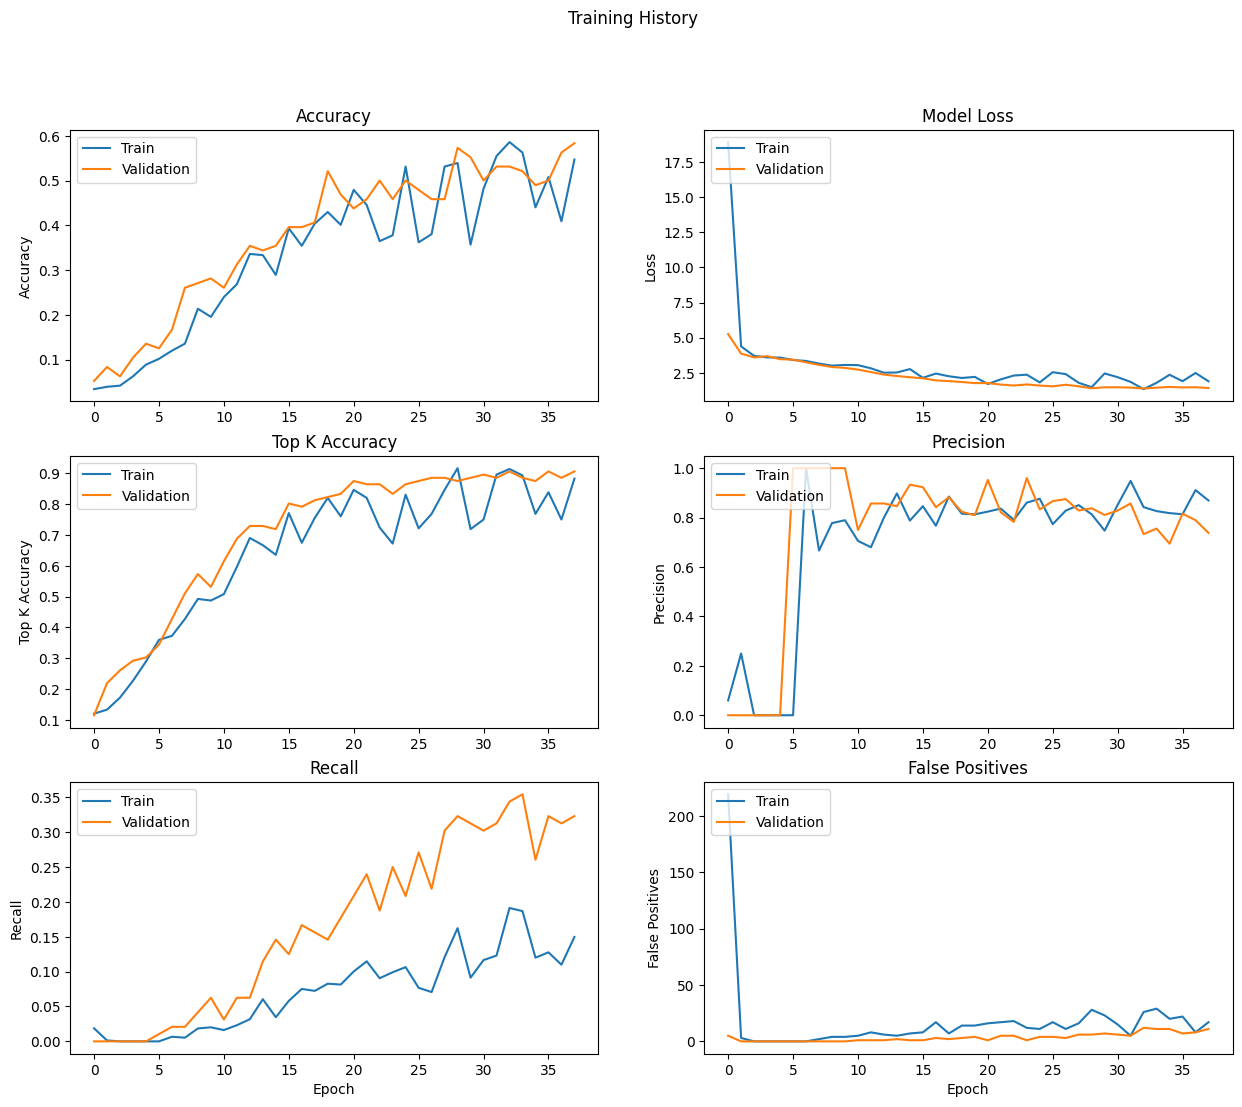

In [ ]:
plot_training_history(resnet50_multi_3_history)

# (4) Optimising Hyperparameters

## Overview
Optimisation search algorithm: BayesianOptimization Tuner

*   `build_fusion_mobilenet_tuning`
*   `build_ann_tuning`
*   `build_cnn_tuning`


In light of limited computational resource, you may consider the usage of the RandomSearch algorithm to reduce time consumption and intensity of the search. However, this may result in different final performance of your model. For more information, please refer to: https://keras.io/api/keras_tuner/

## Functions

In [ ]:
# Directory to store results from hyperparamter tuning, replace with your desired folder name
OPTIM_RESULT_DIR = create_folder(ROOT_RESULT_DIR, 'optimization-results-pp')

In [ ]:
def build_ann_tuning(hp):
  """
  Builds and returns feed-forward model with pre-trained weights for Texture stream
  """

  # Define inputs
  input_texture = Input(shape=(27267,), name="texture_vector")
  x = input_texture

  # Source: https://wandb.ai/arig23498/keras-tuner/reports/Automate-Hyperparameter-Tuning-Using-Keras-Tuner-and-W-B--Vmlldzo0MzQ1NzU
  # Tune number of hidden Dense layers and nodes
  for i in range(hp.Int("mlp_num_layers", 2, 5, default=2)):
    x = Dense(
          units=hp.Int(f"mlp_units_{i}", min_value=32, max_value=160, step=32, default=64),
          activation=hp.Choice(f"mlp_activation_{i}", ["relu", "tanh"], default="relu")
    )(x)

    # Tune Dropout layer with values from 0 to 0.
    x = Dropout(hp.Float(f"mlp_dropout_{i}", 0, 0.4, step=0.1, default=0))(x)

  x = Model(inputs=input_texture, outputs=x)

  return x

In [ ]:
def build_cnn_tuning(base_model, model_name, hp):

  """
  Builds and returns transfer-learning model with pre-trained weights for Colour stream
  with hyperparameter tuning
  """

  # Define inputs
  input_image = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="coloured_image")

  # Freeze convolutional base
  for layer in base_model.layers:
      layer.trainable = False

  # Instantiate pre-trained model
  if 'MobileNet' in model_name:
    # Pre-process input for model
    x = Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)(input_image)

  # Instantiate pre-trained model
  elif 'ResNet50' in model_name:
    # Pre-process input for model
    x = Lambda(tf.keras.applications.resnet_v2.preprocess_input)(input_image)

  else:
    print('Backbone model not found')

  x = base_model(x, training=False)

  # Create fully connected layers
  # Tune pooling layer for max or average
  if hp.Choice('cnn_pooling_', ['avg', 'max']) == 'avg':
    x = GlobalAveragePooling2D()(x)
  elif hp.Choice('cnn_pooling_', ['avg', 'max']) == 'max':
    x = GlobalMaxPooling2D()(x)

  for i in range(hp.Int("cnn_num_layers", 1, 5, default=1)):
    # Tune number of hidden Dense layers and nodes
      x = layers.Dense(
            units=hp.Int(f"cnn_units_{i}", min_value=32, max_value=256, step=32, default=128),
            activation=hp.Choice(f"cnn_activation_{i}", ["relu", "tanh"], default="relu")
      )(x)

      # Tune Dropout layer with values from 0 to 0.5
      x = layers.Dropout(hp.Float(f"cnn_dropout_{i}", 0, 0.4, step=0.1, default=0))(x)

  # Create final model for Colour stream
  x = Model(inputs=input_image, outputs=x)

  return x

In [ ]:
def build_fusion_mobilenet_tuning(hp):
  """
  Build fusion CNN-MLP model for mixed-data inputs and multi-output
  """
  # Define name of model
  model_name = 'MobileNet_Multi'

  # Load MobileNet V2 with ImageNet weights without last fully connected layers
  base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                        weights='imagenet',
                                        include_top=False)

  # Instantiate model for Colour Stream
  x = build_cnn_tuning(base_model, model_name, hp)

  # Instantiate model for Texture Stream
  y = build_ann_tuning(hp)

  # Concatenate two streams together
  combined = layers.concatenate([x.output, y.output], name='concatenation')

  # Define joined Layer
  z = Dense(units=hp.Int("joined_units", min_value=32, max_value=128, step=32),
            activation="relu")(combined)

  # Add Dense layer to output predictions
  z = Dense(NUM_CLASSES, activation='softmax', name='predictions')(z)

  # Define the final model
  model = Model(inputs=[x.input, y.input], outputs=z)

  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'adamw'])

  optimizer_options = {
      'adam': tf.keras.optimizers.Adam(
          learning_rate=hp.Float("lr_adam", min_value=1e-6, max_value=1e-1, sampling="log", default=0.0002),
          weight_decay=hp.Float("wdecay_adam", min_value=1e-6, max_value=1e-1, sampling="log", default=0)
          ),
      'rmsprop': tf.keras.optimizers.RMSprop(
          learning_rate=hp.Float("lr_rmsprop", min_value=1e-6, max_value=1e-1, sampling="log", default=0.0002),
          momentum=hp.Float("momentum_rmsprop", min_value=0, max_value=1, step=0.1, default=0),
          weight_decay=hp.Float("wdecay_rmsprop", min_value=1e-6, max_value=1e-1, sampling="log", default=0),
          centered=hp.Boolean("centered")
          ),
      'adamw': tf.keras.optimizers.experimental.AdamW(
          learning_rate=hp.Float("lr_adamw", min_value=1e-6, max_value=1e-1, sampling="log", default=3e-3),
          weight_decay=hp.Float("wdecay_adamw", min_value=1e-6, max_value=1e-1, sampling="log", default=0.3)
        ),
  }

  # Compile model with selected metrics
  compile_model(model,
                optimizer=optimizer_options[hp_optimizer],
                loss='categorical_crossentropy')

  return model

def build_fusion_resnet_tuning(hp):
  """
  Build fusion CNN-MLP model for mixed-data inputs and multi-output
  """
  # Define name of model
  model_name = 'ResNet50_Multi'

  # Load ResNet50 V2 with ImageNet weights without last fully connected layers
  base_model = ResNet50V2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                        weights='imagenet',
                                        include_top=False)

  # Instantiate model for Colour Stream
  x = build_cnn_tuning(base_model, model_name, hp)

  # Instantiate model for Texture Stream
  y = build_ann_tuning(hp)

  # Concatenate two streams together
  combined = layers.concatenate([x.output, y.output], name='concatenation')

  # Define joined Layer
  z = Dense(units=hp.Int("joined_units", min_value=32, max_value=128, step=32),
            activation="relu")(combined)

  # Add Dense layer to output predictions
  z = Dense(NUM_CLASSES, activation='softmax', name='predictions')(z)

  # Define the final model
  model = Model(inputs=[x.input, y.input], outputs=z)

  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'adamw'])

  optimizer_options = {
      'adam': tf.keras.optimizers.Adam(
          learning_rate=hp.Float("lr_adam", min_value=1e-6, max_value=1e-1, sampling="log", default=0.0002),
          weight_decay=hp.Float("wdecay_adam", min_value=1e-6, max_value=1e-1, sampling="log", default=0)
          ),
      'rmsprop': tf.keras.optimizers.RMSprop(
          learning_rate=hp.Float("lr_rmsprop", min_value=1e-6, max_value=1e-1, sampling="log", default=0.0002),
          momentum=hp.Float("momentum_rmsprop", min_value=0, max_value=1, step=0.1, default=0),
          weight_decay=hp.Float("wdecay_rmsprop", min_value=1e-6, max_value=1e-1, sampling="log", default=0),
          centered=hp.Boolean("centered")
          ),
      'adamw': tf.keras.optimizers.experimental.AdamW(
          learning_rate=hp.Float("lr_adamw", min_value=1e-6, max_value=1e-1, sampling="log", default=3e-3),
          weight_decay=hp.Float("wdecay_adamw", min_value=1e-6, max_value=1e-1, sampling="log", default=0.3)
        ),
  }

  # Compile model with selected metrics
  compile_model(model,
                optimizer=optimizer_options[hp_optimizer],
                loss='categorical_crossentropy')

  return model

## 4.1 MobileNet

### 4.1.1 Build Model and Search

In [ ]:
# Build MobileNetV2 model for hyperparameter tuning
build_fusion_mobilenet_tuning(keras_tuner.HyperParameters())

# Create folder if does not exist
create_folder(OPTIM_RESULT_DIR, 'MobileNet_tuning_BO_2')

# Use BayesianOptimization to search for the best set of hyperparameters
BO_tuner_mobilenet = keras_tuner.BayesianOptimization (
    hypermodel=build_fusion_mobilenet_tuning,
    objective="val_loss",
    max_trials=5,
    # overwrite=True,
    directory=OPTIM_RESULT_DIR,
    project_name=f"{OPTIM_RESULT_DIR}/MobileNet_tuning_BO_2",
)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# View summary of hyperparameters to search
BO_tuner_mobilenet.search_space_summary()

Search space summary
Default search space size: 22
cnn_pooling_ (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
cnn_num_layers (Int)
{'default': 1, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
cnn_units_0 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
cnn_activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
cnn_dropout_0 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
mlp_num_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
mlp_units_0 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': 'linear'}
mlp_activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
mlp_dropout_0 (Floa

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights=True)
# Start the search
BO_tuner_mobilenet.search(
    custom_train_datagen,
    validation_data=custom_val_datagen,
    epochs=50,
    class_weight=class_weights,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Trial 5 Complete [00h 48m 13s]
val_loss: 3.638270139694214

Best val_loss So Far: 2.2430837154388428
Total elapsed time: 02h 59m 02s


In [ ]:
# Print summary of search results
BO_tuner_mobilenet.results_summary()

Results summary
Results in /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/optimization-results-pp/MobileNet_tuning_BO_2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
cnn_pooling_: max
cnn_num_layers: 3
cnn_units_0: 160
cnn_activation_0: relu
cnn_dropout_0: 0.0
mlp_num_layers: 3
mlp_units_0: 160
mlp_activation_0: tanh
mlp_dropout_0: 0.0
mlp_units_1: 64
mlp_activation_1: relu
mlp_dropout_1: 0.30000000000000004
joined_units: 96
optimizer: adam
lr_adam: 0.00021262763943857873
wdecay_adam: 0.014165282963602106
lr_rmsprop: 0.0019245415364393778
momentum_rmsprop: 0.0
wdecay_rmsprop: 4.0171721042662764e-05
centered: False
lr_adamw: 0.00019491000515577312
wdecay_adamw: 1.2460064925767488e-06
cnn_units_1: 128
cnn_activation_1: tanh
cnn_dropout_1: 0.30000000000000004
cnn_units_2: 96
cnn_activation_2: tanh
cnn_dropout_2: 0.30000000000000004
cnn_units_3: 224
cnn_activation_3: relu
cnn_dropout_3: 0.0
mlp_units_2: 160
ml

In [ ]:
# Get best mobilenet model
best_mobilenet_BO = BO_tuner_mobilenet.get_best_models()[0]

In [ ]:
# Get top hyperparameters
best_hps_mobilenet_BO = BO_tuner_mobilenet.get_best_hyperparameters()[0]
print(best_hps_mobilenet_BO.values)

{'cnn_pooling_': 'max', 'cnn_num_layers': 3, 'cnn_units_0': 160, 'cnn_activation_0': 'relu', 'cnn_dropout_0': 0.0, 'mlp_num_layers': 3, 'mlp_units_0': 160, 'mlp_activation_0': 'tanh', 'mlp_dropout_0': 0.0, 'mlp_units_1': 64, 'mlp_activation_1': 'relu', 'mlp_dropout_1': 0.30000000000000004, 'joined_units': 96, 'optimizer': 'adam', 'lr_adam': 0.00021262763943857873, 'wdecay_adam': 0.014165282963602106, 'lr_rmsprop': 0.0019245415364393778, 'momentum_rmsprop': 0.0, 'wdecay_rmsprop': 4.0171721042662764e-05, 'centered': False, 'lr_adamw': 0.00019491000515577312, 'wdecay_adamw': 1.2460064925767488e-06, 'cnn_units_1': 128, 'cnn_activation_1': 'tanh', 'cnn_dropout_1': 0.30000000000000004, 'cnn_units_2': 96, 'cnn_activation_2': 'tanh', 'cnn_dropout_2': 0.30000000000000004, 'cnn_units_3': 224, 'cnn_activation_3': 'relu', 'cnn_dropout_3': 0.0, 'mlp_units_2': 160, 'mlp_activation_2': 'tanh', 'mlp_dropout_2': 0.4, 'mlp_units_3': 64, 'mlp_activation_3': 'tanh', 'mlp_dropout_3': 0.0}


### 4.1.2 Retrain model with entire dataset and best parameters

In [ ]:
# Get top hyperparameters
best_hps_mobilenet_BO = BO_tuner_mobilenet.get_best_hyperparameters(5)

# Build the model with the best hp.
best_mobilenet_BO_retrain = build_fusion_mobilenet_tuning(best_hps_mobilenet_BO[0])

# Fit with the entire dataset.
model_name = "MobileNet_BO"
best_mobilenet_BO_retrain_history, best_mobilenet_BO_retrain, best_mobilenet_BO_retrain_elapsed_time = train_fusion_model(
    best_mobilenet_BO_retrain, model_name,
    train_gen=custom_train_datagen,
    val_gen=custom_val_datagen,
    class_weights=class_weights,
    result_dir=PP_MULTI_RESULT_DIR,
    log_dir=PP_MULTI_TB_DIR,
    additional_callbacks=[early_stopping],
    epochs=30,
    workers=4,
    use_multiprocessing=True,
    version='optimised_BO_2',
    batch_size=BATCH_SIZE)

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 3.8494 - accuracy: 0.0260 - top_k_categorical_accuracy: 0.1068 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 1: val_loss improved from inf to 3.67983, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 64s 5s/step - loss: 3.8494 - accuracy: 0.0260 - top_k_categorical_accuracy: 0.1068 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.6798 - val_accuracy: 0.0417 - val_top_k_categorical_accuracy: 0.1667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 3.7660 - accuracy: 0.0339 - top_k_categorical_accuracy: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 2: val_loss improved from 3.67983 to 3.64738, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 53s 4s/step - loss: 3.7660 - accuracy: 0.0339 - top_k_categorical_accuracy: 0.1562 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.6474 - val_accuracy: 0.0729 - val_top_k_categorical_accuracy: 0.1979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 3.7423 - accuracy: 0.0234 - top_k_categorical_accuracy: 0.1406 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 3: val_loss improved from 3.64738 to 3.62830, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 5s/step - loss: 3.7423 - accuracy: 0.0234 - top_k_categorical_accuracy: 0.1406 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.6283 - val_accuracy: 0.0521 - val_top_k_categorical_accuracy: 0.1979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 3.6810 - accuracy: 0.0391 - top_k_categorical_accuracy: 0.1771 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 4: val_loss improved from 3.62830 to 3.57468, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 5s/step - loss: 3.6810 - accuracy: 0.0391 - top_k_categorical_accuracy: 0.1771 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.5747 - val_accuracy: 0.1042 - val_top_k_categorical_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 5/30
12/12 [==============================] - ETA: 0s - loss: 3.6735 - accuracy: 0.0391 - top_k_categorical_accuracy: 0.1667 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 5: val_loss improved from 3.57468 to 3.55393, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 5s/step - loss: 3.6735 - accuracy: 0.0391 - top_k_categorical_accuracy: 0.1667 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.5539 - val_accuracy: 0.1146 - val_top_k_categorical_accuracy: 0.2812 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 6/30
12/12 [==============================] - ETA: 0s - loss: 3.6927 - accuracy: 0.0339 - top_k_categorical_accuracy: 0.1484 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 6: val_loss improved from 3.55393 to 3.53437, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.6927 - accuracy: 0.0339 - top_k_categorical_accuracy: 0.1484 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.5344 - val_accuracy: 0.0625 - val_top_k_categorical_accuracy: 0.2396 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 7/30
12/12 [==============================] - ETA: 0s - loss: 3.6127 - accuracy: 0.0391 - top_k_categorical_accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 7: val_loss improved from 3.53437 to 3.49501, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.6127 - accuracy: 0.0391 - top_k_categorical_accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4950 - val_accuracy: 0.0729 - val_top_k_categorical_accuracy: 0.3021 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 8/30
11/12 [==========================>...] - ETA: 0s - loss: 3.6344 - accuracy: 0.0426 - top_k_categorical_accuracy: 0.2131 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 8: val_loss improved from 3.49501 to 3.46751, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 58s 5s/step - loss: 3.6347 - accuracy: 0.0443 - top_k_categorical_accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4675 - val_accuracy: 0.0833 - val_top_k_categorical_accuracy: 0.2917 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 9/30
12/12 [==============================] - ETA: 0s - loss: 3.6462 - accuracy: 0.0312 - top_k_categorical_accuracy: 0.1641 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 9: val_loss improved from 3.46751 to 3.42965, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.6462 - accuracy: 0.0312 - top_k_categorical_accuracy: 0.1641 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4296 - val_accuracy: 0.0729 - val_top_k_categorical_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 10/30
12/12 [==============================] - ETA: 0s - loss: 3.5181 - accuracy: 0.0573 - top_k_categorical_accuracy: 0.2448 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 10: val_loss improved from 3.42965 to 3.39881, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.5181 - accuracy: 0.0573 - top_k_categorical_accuracy: 0.2448 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.3988 - val_accuracy: 0.0729 - val_top_k_categorical_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 11/30
12/12 [==============================] - ETA: 0s - loss: 3.6117 - accuracy: 0.0495 - top_k_categorical_accuracy: 0.2109 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 11: val_loss improved from 3.39881 to 3.39825, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.6117 - accuracy: 0.0495 - top_k_categorical_accuracy: 0.2109 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.3982 - val_accuracy: 0.0938 - val_top_k_categorical_accuracy: 0.3438 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 12/30
12/12 [==============================] - ETA: 0s - loss: 3.5017 - accuracy: 0.0651 - top_k_categorical_accuracy: 0.2734 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 12: val_loss improved from 3.39825 to 3.32518, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 56s 5s/step - loss: 3.5017 - accuracy: 0.0651 - top_k_categorical_accuracy: 0.2734 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.3252 - val_accuracy: 0.0417 - val_top_k_categorical_accuracy: 0.4167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 13/30
12/12 [==============================] - ETA: 0s - loss: 3.4856 - accuracy: 0.0755 - top_k_categorical_accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 13: val_loss improved from 3.32518 to 3.29850, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 4s/step - loss: 3.4856 - accuracy: 0.0755 - top_k_categorical_accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.2985 - val_accuracy: 0.1042 - val_top_k_categorical_accuracy: 0.3646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 14/30
12/12 [==============================] - ETA: 0s - loss: 3.3841 - accuracy: 0.1016 - top_k_categorical_accuracy: 0.3151 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 14: val_loss improved from 3.29850 to 3.24689, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.3841 - accuracy: 0.1016 - top_k_categorical_accuracy: 0.3151 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.2469 - val_accuracy: 0.1771 - val_top_k_categorical_accuracy: 0.3854 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 15/30
12/12 [==============================] - ETA: 0s - loss: 3.3892 - accuracy: 0.0990 - top_k_categorical_accuracy: 0.3229 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 15: val_loss improved from 3.24689 to 3.19842, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 4s/step - loss: 3.3892 - accuracy: 0.0990 - top_k_categorical_accuracy: 0.3229 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.1984 - val_accuracy: 0.1667 - val_top_k_categorical_accuracy: 0.3646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 16/30
12/12 [==============================] - ETA: 0s - loss: 3.3104 - accuracy: 0.1224 - top_k_categorical_accuracy: 0.3646 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 16: val_loss improved from 3.19842 to 3.16425, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.3104 - accuracy: 0.1224 - top_k_categorical_accuracy: 0.3646 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.1643 - val_accuracy: 0.2083 - val_top_k_categorical_accuracy: 0.3958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 17/30
11/12 [==========================>...] - ETA: 0s - loss: 3.3959 - accuracy: 0.0994 - top_k_categorical_accuracy: 0.3835 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 17: val_loss improved from 3.16425 to 3.14081, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.4022 - accuracy: 0.0938 - top_k_categorical_accuracy: 0.3776 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.1408 - val_accuracy: 0.1354 - val_top_k_categorical_accuracy: 0.4479 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 18/30
12/12 [==============================] - ETA: 0s - loss: 3.3832 - accuracy: 0.0938 - top_k_categorical_accuracy: 0.3151 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 18: val_loss improved from 3.14081 to 3.10684, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.3832 - accuracy: 0.0938 - top_k_categorical_accuracy: 0.3151 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.1068 - val_accuracy: 0.1562 - val_top_k_categorical_accuracy: 0.3958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 19/30
12/12 [==============================] - ETA: 0s - loss: 3.3647 - accuracy: 0.1042 - top_k_categorical_accuracy: 0.3958 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 19: val_loss did not improve from 3.10684
12/12 [==============================] - 31s 2s/step - loss: 3.3647 - accuracy: 0.1042 - top_k_categorical_accuracy: 0.3958 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.1202 - val_accuracy: 0.1146 - val_top_k_categorical_accuracy: 0.3750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 2

12/12 [==============================] - 55s 5s/step - loss: 3.1307 - accuracy: 0.1458 - top_k_categorical_accuracy: 0.4219 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.0439 - val_accuracy: 0.1458 - val_top_k_categorical_accuracy: 0.3958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 21/30
11/12 [==========================>...] - ETA: 0s - loss: 3.2315 - accuracy: 0.1136 - top_k_categorical_accuracy: 0.4119 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 21: val_loss improved from 3.04393 to 3.02186, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.2432 - accuracy: 0.1094 - top_k_categorical_accuracy: 0.4115 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.0219 - val_accuracy: 0.1875 - val_top_k_categorical_accuracy: 0.4479 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 22/30
12/12 [==============================] - ETA: 0s - loss: 3.1466 - accuracy: 0.1693 - top_k_categorical_accuracy: 0.4609 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 22: val_loss improved from 3.02186 to 2.98643, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 4s/step - loss: 3.1466 - accuracy: 0.1693 - top_k_categorical_accuracy: 0.4609 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.9864 - val_accuracy: 0.1875 - val_top_k_categorical_accuracy: 0.4271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 23/30
12/12 [==============================] - ETA: 0s - loss: 3.0908 - accuracy: 0.1589 - top_k_categorical_accuracy: 0.4479 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 23: val_loss improved from 2.98643 to 2.97328, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 5s/step - loss: 3.0908 - accuracy: 0.1589 - top_k_categorical_accuracy: 0.4479 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.9733 - val_accuracy: 0.1771 - val_top_k_categorical_accuracy: 0.4583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 24/30
12/12 [==============================] - ETA: 0s - loss: 3.0150 - accuracy: 0.1641 - top_k_categorical_accuracy: 0.4792 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 24: val_loss improved from 2.97328 to 2.94872, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 3.0150 - accuracy: 0.1641 - top_k_categorical_accuracy: 0.4792 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.9487 - val_accuracy: 0.1771 - val_top_k_categorical_accuracy: 0.4479 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 25/30
12/12 [==============================] - ETA: 0s - loss: 2.9656 - accuracy: 0.1979 - top_k_categorical_accuracy: 0.4922 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 25: val_loss improved from 2.94872 to 2.88820, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 5s/step - loss: 2.9656 - accuracy: 0.1979 - top_k_categorical_accuracy: 0.4922 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.8882 - val_accuracy: 0.2083 - val_top_k_categorical_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 26/30
12/12 [==============================] - ETA: 0s - loss: 3.0529 - accuracy: 0.1380 - top_k_categorical_accuracy: 0.4740 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 26: val_loss improved from 2.88820 to 2.86518, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 55s 4s/step - loss: 3.0529 - accuracy: 0.1380 - top_k_categorical_accuracy: 0.4740 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.8652 - val_accuracy: 0.1667 - val_top_k_categorical_accuracy: 0.4896 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 27/30
12/12 [==============================] - ETA: 0s - loss: 2.8512 - accuracy: 0.1875 - top_k_categorical_accuracy: 0.5130 - precision: 0.5000 - recall: 0.0014 - false_positives: 1.0000    
Epoch 27: val_loss improved from 2.86518 to 2.81795, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 56s 5s/step - loss: 2.8512 - accuracy: 0.1875 - top_k_categorical_accuracy: 0.5130 - precision: 0.5000 - recall: 0.0014 - false_positives: 1.0000 - val_loss: 2.8179 - val_accuracy: 0.1979 - val_top_k_categorical_accuracy: 0.5521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 28/30
12/12 [==============================] - ETA: 0s - loss: 2.9695 - accuracy: 0.1745 - top_k_categorical_accuracy: 0.5052 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 28: val_loss improved from 2.81795 to 2.80597, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 4s/step - loss: 2.9695 - accuracy: 0.1745 - top_k_categorical_accuracy: 0.5052 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.8060 - val_accuracy: 0.2083 - val_top_k_categorical_accuracy: 0.5208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 29/30
12/12 [==============================] - ETA: 0s - loss: 2.8922 - accuracy: 0.2005 - top_k_categorical_accuracy: 0.5677 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000    
Epoch 29: val_loss improved from 2.80597 to 2.75952, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 54s 4s/step - loss: 2.8922 - accuracy: 0.2005 - top_k_categorical_accuracy: 0.5677 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000 - val_loss: 2.7595 - val_accuracy: 0.2396 - val_top_k_categorical_accuracy: 0.5833 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 30/30
12/12 [==============================] - ETA: 0s - loss: 3.2519 - accuracy: 0.1589 - top_k_categorical_accuracy: 0.4010 - precision: 1.0000 - recall: 0.0026 - false_positives: 0.0000e+00
Epoch 30: val_loss improved from 2.75952 to 2.74321, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_BO/MobileNet_BO_optimised_BO_2


12/12 [==============================] - 53s 4s/step - loss: 3.2519 - accuracy: 0.1589 - top_k_categorical_accuracy: 0.4010 - precision: 1.0000 - recall: 0.0026 - false_positives: 0.0000e+00 - val_loss: 2.7432 - val_accuracy: 0.2500 - val_top_k_categorical_accuracy: 0.5417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00


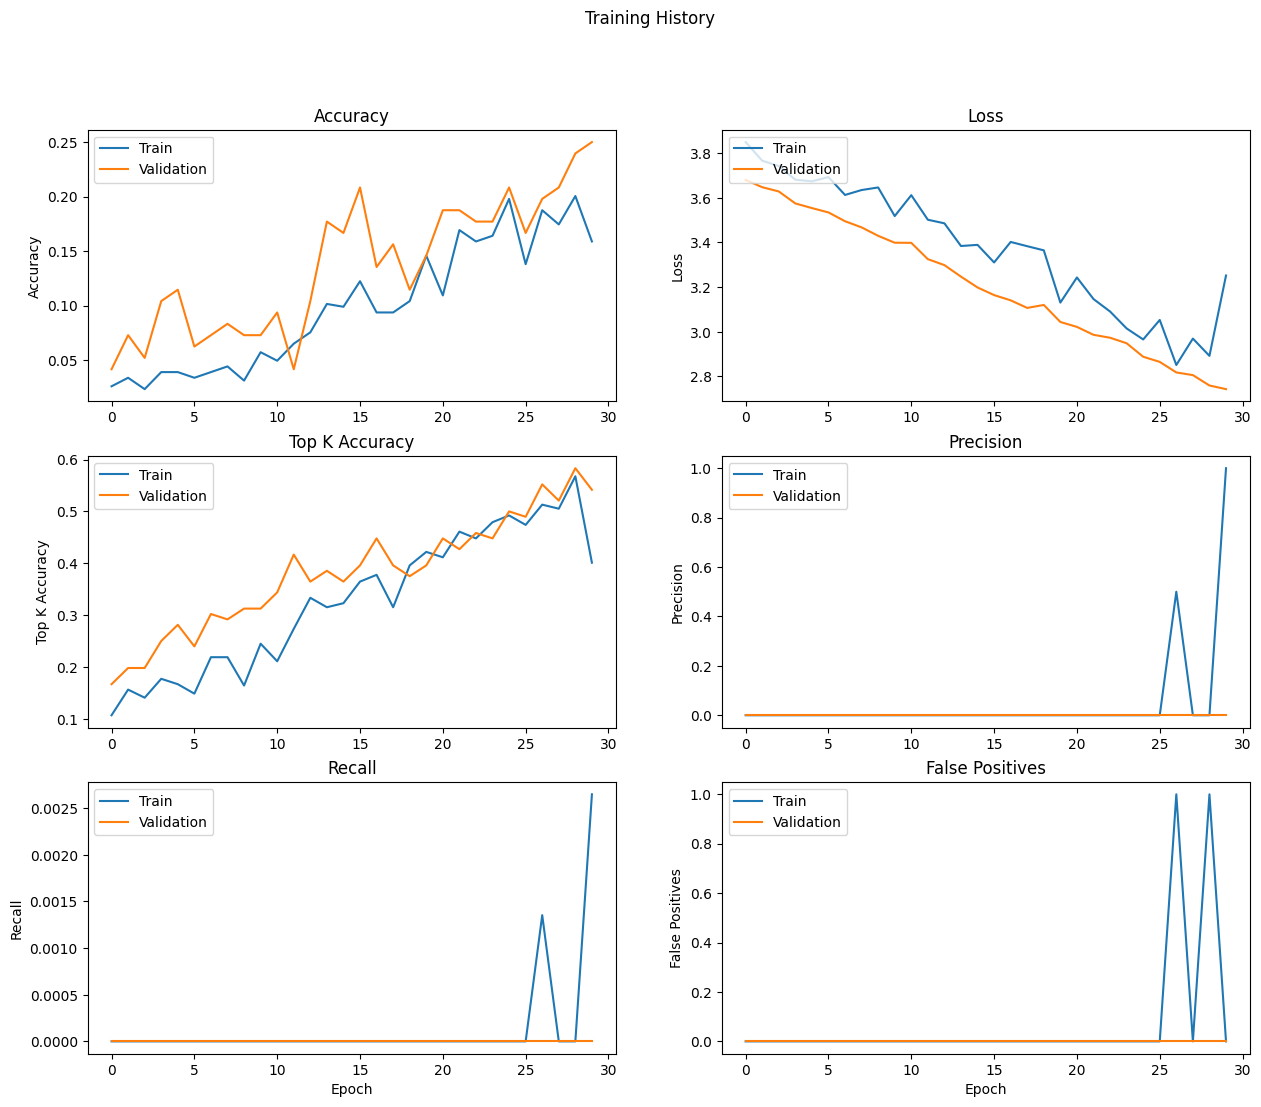

In [ ]:
plot_training_history(best_mobilenet_BO_retrain_history)

In [ ]:
print(best_mobilenet_BO_retrain_elapsed_time)

1642.0909781500013


In [ ]:
tf.keras.backend.get_value(best_mobilenet_BO_retrain.optimizer.lr)

0.0019833583

## 4.2 ResNet-50

### 4.2.1 Build Model and Search

In [ ]:
# Build ResNet50V2 model for hyperparameter tuning
build_fusion_resnet_tuning(keras_tuner.HyperParameters())

# Create folder if does not exist
create_folder(OPTIM_RESULT_DIR, 'ResNet50_tuning_BO')

# Use BayesianOptimization algorithm to search for the best set of hyperparameters
BO_tuner_resnet = keras_tuner.BayesianOptimization (
    hypermodel=build_fusion_resnet_tuning,
    objective="val_loss",
    max_trials=5,
    # overwrite=True,
    directory=OPTIM_RESULT_DIR,
    project_name=f"{OPTIM_RESULT_DIR}/ResNet50_tuning_BO_2",
)

94668760/94668760 [==============================] - 3s 0us/step
Folder exists


In [ ]:
# Get summary of hyperparameters to explore
BO_tuner_resnet.search_space_summary()

Search space summary
Default search space size: 22
cnn_pooling_ (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
cnn_num_layers (Int)
{'default': 1, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
cnn_units_0 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
cnn_activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
cnn_dropout_0 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
mlp_num_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
mlp_units_0 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': 'linear'}
mlp_activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
mlp_dropout_0 (Floa

In [ ]:
# Initialise early stopping callback
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=4,
                               restore_best_weights=True)
# Start search
BO_tuner_resnet.search(
    custom_train_datagen,
    validation_data=custom_val_datagen,
    epochs=50,
    class_weight=class_weights,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Trial 5 Complete [00h 03m 48s]
val_loss: 3.0281107425689697

Best val_loss So Far: 1.3705930709838867
Total elapsed time: 00h 18m 35s


In [ ]:
# Print summary of search results
BO_tuner_resnet.results_summary()

Results summary
Results in /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/optimization-results-pp/ResNet50_tuning_BO
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
cnn_pooling_: avg
cnn_num_layers: 1
cnn_units_0: 256
cnn_activation_0: relu
cnn_dropout_0: 0.0
mlp_num_layers: 5
mlp_units_0: 16
mlp_activation_0: tanh
mlp_dropout_0: 0.4
mlp_units_1: 16
mlp_activation_1: tanh
mlp_dropout_1: 0.4
joined_units: 64
optimizer: adam
lr_adam: 0.004546946600004221
wdecay_adam: 2.70189181160165e-06
lr_rmsprop: 9.009952912480081e-05
momentum_rmsprop: 0.6000000000000001
wdecay_rmsprop: 7.360647072220591e-06
centered: False
lr_adamw: 0.004956310829734017
wdecay_adamw: 1.3129314700467856e-06
cnn_units_1: 256
cnn_activation_1: relu
cnn_dropout_1: 0.1
cnn_units_2: 64
cnn_activation_2: tanh
cnn_dropout_2: 0.4
mlp_units_2: 144
mlp_activation_2: relu
mlp_dropout_2: 0.30000000000000004
mlp_units_3: 144
mlp_activation_3: relu
mlp_d

In [ ]:
# Get best resnet50 model
best_resnet_BO = BO_tuner_resnet.get_best_models()[0]

In [ ]:
# Get top hyperparameters
best_hps_resnet_BO = BO_tuner_resnet.get_best_hyperparameters()[0]
print(best_hps_resnet_BO.values)

{'cnn_pooling_': 'max', 'cnn_num_layers': 2, 'cnn_units_0': 64, 'cnn_activation_0': 'tanh', 'cnn_dropout_0': 0.4, 'mlp_num_layers': 4, 'mlp_units_0': 160, 'mlp_activation_0': 'tanh', 'mlp_dropout_0': 0.1, 'mlp_units_1': 160, 'mlp_activation_1': 'relu', 'mlp_dropout_1': 0.0, 'joined_units': 64, 'optimizer': 'rmsprop', 'lr_adam': 4.00061797319315e-06, 'wdecay_adam': 2.658941653164541e-05, 'lr_rmsprop': 1.0752810184567666e-06, 'momentum_rmsprop': 0.2, 'wdecay_rmsprop': 0.0578897305814024, 'centered': True, 'lr_adamw': 3.772859356566199e-05, 'wdecay_adamw': 0.0960546093569829, 'cnn_units_1': 128, 'cnn_activation_1': 'relu', 'cnn_dropout_1': 0, 'mlp_units_2': 64, 'mlp_activation_2': 'relu', 'mlp_dropout_2': 0, 'mlp_units_3': 64, 'mlp_activation_3': 'relu', 'mlp_dropout_3': 0}


In [ ]:
# Retrain model with entire dataset
# Get the top hyperparameters
best_hps_resnet = BO_tuner_resnet.get_best_hyperparameters(5)

# Build the model with the best hp.
best_resnet_BO_retrain = build_fusion_resnet_tuning(best_hps_resnet[0])

# Fit with the entire dataset.
model_name = "ResNet50_BO"
best_resnet_BO_retrain_history, best_resnet_BO_retrain, best_resnet_BO_retrain_elapsed_time = train_fusion_model(
    best_resnet_BO_retrain, model_name,
    train_gen=custom_train_datagen,
    val_gen=custom_val_datagen,
    class_weights=class_weights,
    result_dir=PP_MULTI_RESULT_DIR,
    log_dir=PP_MULTI_TB_DIR,
    additional_callbacks=[early_stopping],
    epochs=100,
    workers=4,
    use_multiprocessing=True,
    version='optimised_BO',
    batch_size=BATCH_SIZE)

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 3.6939 - accuracy: 0.0417 - top_k_categorical_accuracy: 0.1250 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 1: val_loss improved from inf to 3.60869, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 50s 4s/step - loss: 3.6939 - accuracy: 0.0417 - top_k_categorical_accuracy: 0.1250 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.6087 - val_accuracy: 0.0625 - val_top_k_categorical_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 3.6236 - accuracy: 0.0495 - top_k_categorical_accuracy: 0.2266 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 2: val_loss improved from 3.60869 to 3.50420, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 3.6236 - accuracy: 0.0495 - top_k_categorical_accuracy: 0.2266 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.5042 - val_accuracy: 0.0521 - val_top_k_categorical_accuracy: 0.2604 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 3.5636 - accuracy: 0.0651 - top_k_categorical_accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 3: val_loss improved from 3.50420 to 3.43464, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 3.5636 - accuracy: 0.0651 - top_k_categorical_accuracy: 0.2188 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4346 - val_accuracy: 0.0729 - val_top_k_categorical_accuracy: 0.2708 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 3.4617 - accuracy: 0.0677 - top_k_categorical_accuracy: 0.2760 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 4: val_loss improved from 3.43464 to 3.34328, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 3.4617 - accuracy: 0.0677 - top_k_categorical_accuracy: 0.2760 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.3433 - val_accuracy: 0.0625 - val_top_k_categorical_accuracy: 0.3229 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 5/100
11/12 [==========================>...] - ETA: 0s - loss: 3.3772 - accuracy: 0.0881 - top_k_categorical_accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 5: val_loss improved from 3.34328 to 3.22034, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 3.3831 - accuracy: 0.0885 - top_k_categorical_accuracy: 0.3125 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.2203 - val_accuracy: 0.0833 - val_top_k_categorical_accuracy: 0.3750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 6/100
12/12 [==============================] - ETA: 0s - loss: 3.3136 - accuracy: 0.0781 - top_k_categorical_accuracy: 0.2995 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000    
Epoch 6: val_loss improved from 3.22034 to 3.17190, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 3.3136 - accuracy: 0.0781 - top_k_categorical_accuracy: 0.2995 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000 - val_loss: 3.1719 - val_accuracy: 0.0521 - val_top_k_categorical_accuracy: 0.3750 - val_precision: 1.0000 - val_recall: 0.0208 - val_false_positives: 0.0000e+00
Epoch 7/100
12/12 [==============================] - ETA: 0s - loss: 3.1984 - accuracy: 0.0938 - top_k_categorical_accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000
Epoch 7: val_loss improved from 3.17190 to 3.00281, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 38s 3s/step - loss: 3.1984 - accuracy: 0.0938 - top_k_categorical_accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 1.0000 - val_loss: 3.0028 - val_accuracy: 0.0833 - val_top_k_categorical_accuracy: 0.4479 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 8/100
12/12 [==============================] - ETA: 0s - loss: 3.3811 - accuracy: 0.0885 - top_k_categorical_accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 8: val_loss did not improve from 3.00281
12/12 [==============================] - 12s 994ms/step - loss: 3.3811 - accuracy: 0.0885 - top_k_categorical_accuracy: 0.3333 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.0333 - val_accuracy: 0.1458 - val_top_k_categorical_accuracy: 0.3646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 9/1

12/12 [==============================] - 40s 3s/step - loss: 3.3266 - accuracy: 0.0833 - top_k_categorical_accuracy: 0.3542 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.8915 - val_accuracy: 0.1771 - val_top_k_categorical_accuracy: 0.5312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 10/100
12/12 [==============================] - ETA: 0s - loss: 3.1509 - accuracy: 0.1406 - top_k_categorical_accuracy: 0.4401 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 10: val_loss did not improve from 2.89151
12/12 [==============================] - 12s 1s/step - loss: 3.1509 - accuracy: 0.1406 - top_k_categorical_accuracy: 0.4401 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.9117 - val_accuracy: 0.1667 - val_top_k_categorical_accuracy: 0.4375 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 

12/12 [==============================] - 39s 3s/step - loss: 3.0650 - accuracy: 0.1302 - top_k_categorical_accuracy: 0.4115 - precision: 1.0000 - recall: 0.0069 - false_positives: 0.0000e+00 - val_loss: 2.7612 - val_accuracy: 0.1667 - val_top_k_categorical_accuracy: 0.5417 - val_precision: 0.6667 - val_recall: 0.0208 - val_false_positives: 1.0000
Epoch 12/100
12/12 [==============================] - ETA: 0s - loss: 3.0371 - accuracy: 0.1224 - top_k_categorical_accuracy: 0.4870 - precision: 0.6250 - recall: 0.0066 - false_positives: 3.0000
Epoch 12: val_loss improved from 2.76116 to 2.66989, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 3.0371 - accuracy: 0.1224 - top_k_categorical_accuracy: 0.4870 - precision: 0.6250 - recall: 0.0066 - false_positives: 3.0000 - val_loss: 2.6699 - val_accuracy: 0.2188 - val_top_k_categorical_accuracy: 0.5729 - val_precision: 1.0000 - val_recall: 0.0208 - val_false_positives: 0.0000e+00
Epoch 13/100
12/12 [==============================] - ETA: 0s - loss: 2.8231 - accuracy: 0.1432 - top_k_categorical_accuracy: 0.5547 - precision: 0.6667 - recall: 0.0027 - false_positives: 1.0000
Epoch 13: val_loss improved from 2.66989 to 2.59799, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 2.8231 - accuracy: 0.1432 - top_k_categorical_accuracy: 0.5547 - precision: 0.6667 - recall: 0.0027 - false_positives: 1.0000 - val_loss: 2.5980 - val_accuracy: 0.2083 - val_top_k_categorical_accuracy: 0.6667 - val_precision: 0.3333 - val_recall: 0.0208 - val_false_positives: 4.0000
Epoch 14/100
12/12 [==============================] - ETA: 0s - loss: 2.5153 - accuracy: 0.1849 - top_k_categorical_accuracy: 0.6016 - precision: 0.7273 - recall: 0.0107 - false_positives: 3.0000
Epoch 14: val_loss improved from 2.59799 to 2.49487, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 2.5153 - accuracy: 0.1849 - top_k_categorical_accuracy: 0.6016 - precision: 0.7273 - recall: 0.0107 - false_positives: 3.0000 - val_loss: 2.4949 - val_accuracy: 0.2083 - val_top_k_categorical_accuracy: 0.6042 - val_precision: 1.0000 - val_recall: 0.0312 - val_false_positives: 0.0000e+00
Epoch 15/100
12/12 [==============================] - ETA: 0s - loss: 2.6837 - accuracy: 0.2005 - top_k_categorical_accuracy: 0.5833 - precision: 0.6923 - recall: 0.0240 - false_positives: 8.0000
Epoch 15: val_loss improved from 2.49487 to 2.41602, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 2.6837 - accuracy: 0.2005 - top_k_categorical_accuracy: 0.5833 - precision: 0.6923 - recall: 0.0240 - false_positives: 8.0000 - val_loss: 2.4160 - val_accuracy: 0.2188 - val_top_k_categorical_accuracy: 0.6354 - val_precision: 0.6000 - val_recall: 0.0625 - val_false_positives: 4.0000
Epoch 16/100
12/12 [==============================] - ETA: 0s - loss: 2.9627 - accuracy: 0.1667 - top_k_categorical_accuracy: 0.5130 - precision: 0.6667 - recall: 0.0160 - false_positives: 6.0000
Epoch 16: val_loss did not improve from 2.41602
12/12 [==============================] - 12s 1s/step - loss: 2.9627 - accuracy: 0.1667 - top_k_categorical_accuracy: 0.5130 - precision: 0.6667 - recall: 0.0160 - false_positives: 6.0000 - val_loss: 2.4670 - val_accuracy: 0.2188 - val_top_k_categorical_accuracy: 0.6771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00
Epoch 17/100
12/12 [==============================] - 

12/12 [==============================] - 39s 3s/step - loss: 2.6514 - accuracy: 0.2396 - top_k_categorical_accuracy: 0.6224 - precision: 0.7333 - recall: 0.0147 - false_positives: 4.0000 - val_loss: 2.2422 - val_accuracy: 0.2917 - val_top_k_categorical_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.0208 - val_false_positives: 0.0000e+00
Epoch 18/100
12/12 [==============================] - ETA: 0s - loss: 2.3241 - accuracy: 0.2240 - top_k_categorical_accuracy: 0.6797 - precision: 0.8261 - recall: 0.0254 - false_positives: 4.0000
Epoch 18: val_loss improved from 2.24224 to 2.16669, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 40s 3s/step - loss: 2.3241 - accuracy: 0.2240 - top_k_categorical_accuracy: 0.6797 - precision: 0.8261 - recall: 0.0254 - false_positives: 4.0000 - val_loss: 2.1667 - val_accuracy: 0.3021 - val_top_k_categorical_accuracy: 0.7500 - val_precision: 0.8889 - val_recall: 0.0833 - val_false_positives: 1.0000
Epoch 19/100
12/12 [==============================] - ETA: 0s - loss: 2.7068 - accuracy: 0.2031 - top_k_categorical_accuracy: 0.6458 - precision: 0.6977 - recall: 0.0399 - false_positives: 13.0000
Epoch 19: val_loss did not improve from 2.16669
12/12 [==============================] - 12s 1s/step - loss: 2.7068 - accuracy: 0.2031 - top_k_categorical_accuracy: 0.6458 - precision: 0.6977 - recall: 0.0399 - false_positives: 13.0000 - val_loss: 2.3977 - val_accuracy: 0.1562 - val_top_k_categorical_accuracy: 0.7396 - val_precision: 0.5000 - val_recall: 0.0208 - val_false_positives: 2.0000
Epoch 20/100
12/12 [==============================] - ETA: 0s - 

12/12 [==============================] - 39s 3s/step - loss: 2.3101 - accuracy: 0.2734 - top_k_categorical_accuracy: 0.7240 - precision: 0.6250 - recall: 0.0067 - false_positives: 3.0000 - val_loss: 2.1297 - val_accuracy: 0.3542 - val_top_k_categorical_accuracy: 0.8021 - val_precision: 0.8000 - val_recall: 0.0417 - val_false_positives: 1.0000
Epoch 22/100
12/12 [==============================] - ETA: 0s - loss: 2.7429 - accuracy: 0.2552 - top_k_categorical_accuracy: 0.6406 - precision: 0.6136 - recall: 0.0359 - false_positives: 17.0000
Epoch 22: val_loss did not improve from 2.12966
12/12 [==============================] - 12s 1s/step - loss: 2.7429 - accuracy: 0.2552 - top_k_categorical_accuracy: 0.6406 - precision: 0.6136 - recall: 0.0359 - false_positives: 17.0000 - val_loss: 2.2423 - val_accuracy: 0.3333 - val_top_k_categorical_accuracy: 0.7188 - val_precision: 0.8889 - val_recall: 0.0833 - val_false_positives: 1.0000
Epoch 23/100
12/12 [==============================] - ETA: 0s - 

12/12 [==============================] - 40s 3s/step - loss: 2.6348 - accuracy: 0.2292 - top_k_categorical_accuracy: 0.6380 - precision: 0.5938 - recall: 0.0251 - false_positives: 13.0000 - val_loss: 2.1137 - val_accuracy: 0.3646 - val_top_k_categorical_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.0833 - val_false_positives: 3.0000
Epoch 25/100
12/12 [==============================] - ETA: 0s - loss: 2.5586 - accuracy: 0.2708 - top_k_categorical_accuracy: 0.6797 - precision: 0.7273 - recall: 0.0326 - false_positives: 9.0000
Epoch 25: val_loss did not improve from 2.11368
12/12 [==============================] - 13s 1s/step - loss: 2.5586 - accuracy: 0.2708 - top_k_categorical_accuracy: 0.6797 - precision: 0.7273 - recall: 0.0326 - false_positives: 9.0000 - val_loss: 2.1721 - val_accuracy: 0.2812 - val_top_k_categorical_accuracy: 0.7188 - val_precision: 0.6667 - val_recall: 0.1042 - val_false_positives: 5.0000
Epoch 26/100
12/12 [==============================] - ETA: 0s - l

12/12 [==============================] - 39s 3s/step - loss: 2.1289 - accuracy: 0.3229 - top_k_categorical_accuracy: 0.7760 - precision: 0.6889 - recall: 0.0411 - false_positives: 14.0000 - val_loss: 1.9639 - val_accuracy: 0.3542 - val_top_k_categorical_accuracy: 0.7812 - val_precision: 0.6667 - val_recall: 0.1250 - val_false_positives: 6.0000
Epoch 27/100
12/12 [==============================] - ETA: 0s - loss: 2.4143 - accuracy: 0.2865 - top_k_categorical_accuracy: 0.6823 - precision: 0.6757 - recall: 0.0668 - false_positives: 24.0000
Epoch 27: val_loss did not improve from 1.96392
12/12 [==============================] - 10s 832ms/step - loss: 2.4143 - accuracy: 0.2865 - top_k_categorical_accuracy: 0.6823 - precision: 0.6757 - recall: 0.0668 - false_positives: 24.0000 - val_loss: 2.1020 - val_accuracy: 0.3438 - val_top_k_categorical_accuracy: 0.7500 - val_precision: 0.8000 - val_recall: 0.1250 - val_false_positives: 3.0000
Epoch 28/100
12/12 [==============================] - ETA: 0

12/12 [==============================] - 39s 3s/step - loss: 2.8359 - accuracy: 0.2474 - top_k_categorical_accuracy: 0.6432 - precision: 0.8438 - recall: 0.0360 - false_positives: 5.0000 - val_loss: 1.8855 - val_accuracy: 0.3646 - val_top_k_categorical_accuracy: 0.8229 - val_precision: 0.9231 - val_recall: 0.1250 - val_false_positives: 1.0000
Epoch 30/100
12/12 [==============================] - ETA: 0s - loss: 2.4777 - accuracy: 0.3047 - top_k_categorical_accuracy: 0.7708 - precision: 0.7391 - recall: 0.0229 - false_positives: 6.0000
Epoch 30: val_loss improved from 1.88553 to 1.80409, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 40s 3s/step - loss: 2.4777 - accuracy: 0.3047 - top_k_categorical_accuracy: 0.7708 - precision: 0.7391 - recall: 0.0229 - false_positives: 6.0000 - val_loss: 1.8041 - val_accuracy: 0.4167 - val_top_k_categorical_accuracy: 0.8646 - val_precision: 0.7333 - val_recall: 0.1146 - val_false_positives: 4.0000
Epoch 31/100
11/12 [==========================>...] - ETA: 0s - loss: 2.1481 - accuracy: 0.3494 - top_k_categorical_accuracy: 0.7955 - precision: 0.8140 - recall: 0.0507 - false_positives: 8.0000
Epoch 31: val_loss improved from 1.80409 to 1.73718, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 40s 3s/step - loss: 2.1204 - accuracy: 0.3542 - top_k_categorical_accuracy: 0.8047 - precision: 0.8163 - recall: 0.0532 - false_positives: 9.0000 - val_loss: 1.7372 - val_accuracy: 0.3646 - val_top_k_categorical_accuracy: 0.8646 - val_precision: 0.7391 - val_recall: 0.1771 - val_false_positives: 6.0000
Epoch 32/100
12/12 [==============================] - ETA: 0s - loss: 2.6507 - accuracy: 0.2656 - top_k_categorical_accuracy: 0.6823 - precision: 0.7447 - recall: 0.0470 - false_positives: 12.0000
Epoch 32: val_loss did not improve from 1.73718
12/12 [==============================] - 12s 1s/step - loss: 2.6507 - accuracy: 0.2656 - top_k_categorical_accuracy: 0.6823 - precision: 0.7447 - recall: 0.0470 - false_positives: 12.0000 - val_loss: 1.8144 - val_accuracy: 0.3750 - val_top_k_categorical_accuracy: 0.8750 - val_precision: 0.7000 - val_recall: 0.1458 - val_false_positives: 6.0000
Epoch 33/100
12/12 [==============================] - ETA: 0s - 

12/12 [==============================] - 39s 3s/step - loss: 2.0513 - accuracy: 0.3620 - top_k_categorical_accuracy: 0.8255 - precision: 0.6234 - recall: 0.0641 - false_positives: 29.0000 - val_loss: 1.7217 - val_accuracy: 0.3750 - val_top_k_categorical_accuracy: 0.8542 - val_precision: 0.9130 - val_recall: 0.2188 - val_false_positives: 2.0000
Epoch 36/100
12/12 [==============================] - ETA: 0s - loss: 2.4396 - accuracy: 0.2995 - top_k_categorical_accuracy: 0.7474 - precision: 0.8154 - recall: 0.0698 - false_positives: 12.0000
Epoch 36: val_loss did not improve from 1.72168
12/12 [==============================] - 12s 1s/step - loss: 2.4396 - accuracy: 0.2995 - top_k_categorical_accuracy: 0.7474 - precision: 0.8154 - recall: 0.0698 - false_positives: 12.0000 - val_loss: 1.7804 - val_accuracy: 0.4479 - val_top_k_categorical_accuracy: 0.8646 - val_precision: 0.7333 - val_recall: 0.1146 - val_false_positives: 4.0000
Epoch 37/100
12/12 [==============================] - ETA: 0s -

12/12 [==============================] - 39s 3s/step - loss: 2.0968 - accuracy: 0.3646 - top_k_categorical_accuracy: 0.8255 - precision: 0.7755 - recall: 0.0510 - false_positives: 11.0000 - val_loss: 1.6646 - val_accuracy: 0.4167 - val_top_k_categorical_accuracy: 0.8958 - val_precision: 0.7619 - val_recall: 0.1667 - val_false_positives: 5.0000
Epoch 40/100
12/12 [==============================] - ETA: 0s - loss: 1.7745 - accuracy: 0.4167 - top_k_categorical_accuracy: 0.8307 - precision: 0.7476 - recall: 0.1066 - false_positives: 26.0000
Epoch 40: val_loss improved from 1.66457 to 1.65077, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 1.7745 - accuracy: 0.4167 - top_k_categorical_accuracy: 0.8307 - precision: 0.7476 - recall: 0.1066 - false_positives: 26.0000 - val_loss: 1.6508 - val_accuracy: 0.4271 - val_top_k_categorical_accuracy: 0.8646 - val_precision: 0.6452 - val_recall: 0.2083 - val_false_positives: 11.0000
Epoch 41/100
12/12 [==============================] - ETA: 0s - loss: 1.8440 - accuracy: 0.3672 - top_k_categorical_accuracy: 0.8568 - precision: 0.6261 - recall: 0.0951 - false_positives: 43.0000
Epoch 41: val_loss improved from 1.65077 to 1.53337, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 1.8440 - accuracy: 0.3672 - top_k_categorical_accuracy: 0.8568 - precision: 0.6261 - recall: 0.0951 - false_positives: 43.0000 - val_loss: 1.5334 - val_accuracy: 0.4688 - val_top_k_categorical_accuracy: 0.9167 - val_precision: 0.6875 - val_recall: 0.2292 - val_false_positives: 10.0000
Epoch 42/100
12/12 [==============================] - ETA: 0s - loss: 2.5851 - accuracy: 0.2995 - top_k_categorical_accuracy: 0.7734 - precision: 0.7297 - recall: 0.0722 - false_positives: 20.0000
Epoch 42: val_loss did not improve from 1.53337
12/12 [==============================] - 13s 1s/step - loss: 2.5851 - accuracy: 0.2995 - top_k_categorical_accuracy: 0.7734 - precision: 0.7297 - recall: 0.0722 - false_positives: 20.0000 - val_loss: 1.6491 - val_accuracy: 0.4688 - val_top_k_categorical_accuracy: 0.9375 - val_precision: 0.8571 - val_recall: 0.1250 - val_false_positives: 2.0000
Epoch 43/100
11/12 [==========================>...] - ETA: 0s 

12/12 [==============================] - 40s 3s/step - loss: 1.8952 - accuracy: 0.4141 - top_k_categorical_accuracy: 0.8359 - precision: 0.7778 - recall: 0.0652 - false_positives: 14.0000 - val_loss: 1.5168 - val_accuracy: 0.4271 - val_top_k_categorical_accuracy: 0.9167 - val_precision: 0.7407 - val_recall: 0.2083 - val_false_positives: 7.0000
Epoch 44/100
11/12 [==========================>...] - ETA: 0s - loss: 1.7049 - accuracy: 0.4091 - top_k_categorical_accuracy: 0.8835 - precision: 0.8043 - recall: 0.1060 - false_positives: 18.0000
Epoch 44: val_loss improved from 1.51683 to 1.47850, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_BO/ResNet50_BO_optimised_BO


12/12 [==============================] - 39s 3s/step - loss: 1.6952 - accuracy: 0.4115 - top_k_categorical_accuracy: 0.8828 - precision: 0.8200 - recall: 0.1076 - false_positives: 18.0000 - val_loss: 1.4785 - val_accuracy: 0.4583 - val_top_k_categorical_accuracy: 0.9062 - val_precision: 0.7812 - val_recall: 0.2604 - val_false_positives: 7.0000
Epoch 45/100
12/12 [==============================] - ETA: 0s - loss: 1.8129 - accuracy: 0.4349 - top_k_categorical_accuracy: 0.8828 - precision: 0.7288 - recall: 0.1133 - false_positives: 32.0000
Epoch 45: val_loss did not improve from 1.47850
12/12 [==============================] - 13s 1s/step - loss: 1.8129 - accuracy: 0.4349 - top_k_categorical_accuracy: 0.8828 - precision: 0.7288 - recall: 0.1133 - false_positives: 32.0000 - val_loss: 1.6106 - val_accuracy: 0.4062 - val_top_k_categorical_accuracy: 0.8750 - val_precision: 0.6970 - val_recall: 0.2396 - val_false_positives: 10.0000
Epoch 46/100
12/12 [==============================] - ETA: 0s 

In [ ]:
save_model_archi(best_resnet_BO_retrain, model_name)

Saved to ResNet50_BO


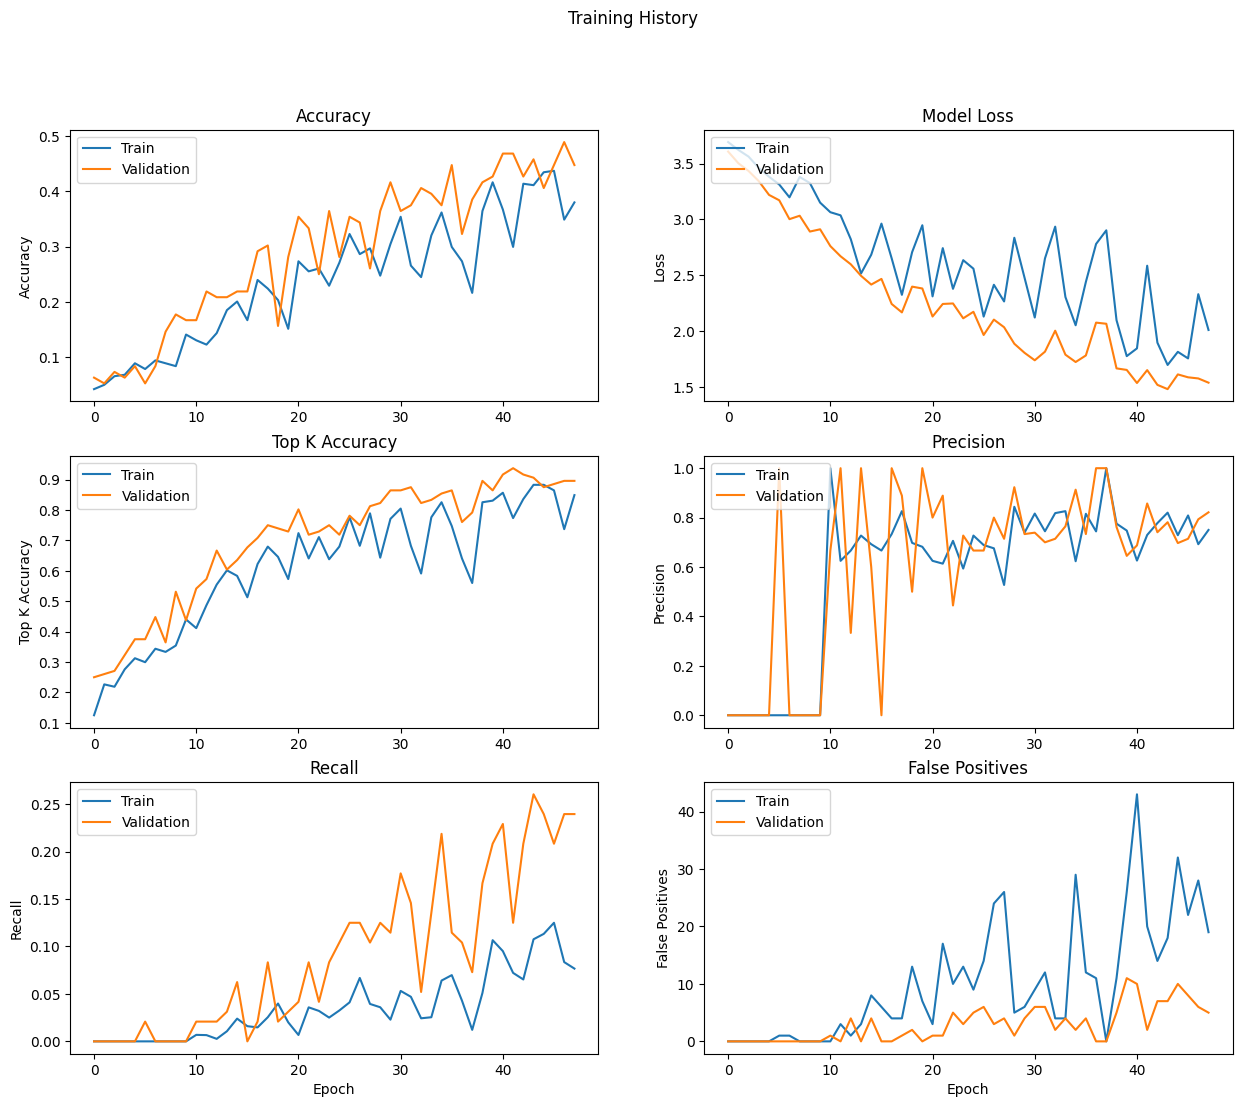

In [ ]:
plot_training_history(best_resnet_BO_retrain_history)

In [ ]:
tf.keras.backend.get_value(best_resnet_BO_retrain.optimizer.lr)

0.0019833583

# (5) Fine-tuning: Unfreezing Selected Layers

This section utilises models with parameters from Section 3 in favour of the learning curves observed. In particular, the MobileNet version of Section 4 highlighted its inability to learn meaningfully from mixed-data type features.

Rather than loading saved models, we will train a model on fewer epochs of 30 to determine the benefit of fine-tuning in this implementation with a sparse dataset that does not bear much similarity with the ImageNet dataset.

## 5.1 MobileNet: Unfreezing the Last Block



### 5.1.1 Build and Compile Model

In [ ]:
# # Clear existing session if needed
# tf.keras.backend.clear_session()

In [ ]:
model_name = 'MobileNet_Multi'

# Load MobileNet V2 with ImageNet weights without last fully connected layers
mobilenet_base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                      weights='imagenet',
                                      include_top=False)

mobilenet_multi_4 = build_fusion_model(mobilenet_base_model,
                                       model_name,
                                       is_trainable=False)

Backbone model:  MobileNet_Multi
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 coloured_image (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['coloured_image[0][0]']         
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['lambda[0][0]']                 
 al)                                                                                              
                                                           

In [ ]:
# View trainable variables in the base model
len(mobilenet_multi_4.trainable_variables)

14

In [ ]:
# Compile model
mobilenet_multi_4 = compile_model(mobilenet_multi_4, optimizer=Adam())

In [ ]:
initial_epochs = 30

# Train fusion model on 30 epochs
mobilenet_multi_4_history, mobilenet_multi_4, mobilenet_multi_4_elapsed_time = train_fusion_model(
    mobilenet_multi_4, model_name,
    train_gen=custom_train_datagen,
    val_gen=custom_val_datagen,
    class_weights=class_weights,
    result_dir=PP_MULTI_RESULT_DIR,
    log_dir=PP_MULTI_TB_DIR,
    additional_callbacks=add_callbacks(5),
    epochs=initial_epochs,
    workers=4,
    use_multiprocessing=True,
    version='v4',
    batch_size=BATCH_SIZE)

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 9.0844 - accuracy: 0.0182 - top_k_categorical_accuracy: 0.1354 - precision: 0.0152 - recall: 0.0014 - false_positives: 65.0000 
Epoch 1: val_loss improved from inf to 3.76774, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 58s 4s/step - loss: 9.0844 - accuracy: 0.0182 - top_k_categorical_accuracy: 0.1354 - precision: 0.0152 - recall: 0.0014 - false_positives: 65.0000 - val_loss: 3.7677 - val_accuracy: 0.0208 - val_top_k_categorical_accuracy: 0.1562 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 3.7219 - accuracy: 0.0286 - top_k_categorical_accuracy: 0.1328 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 2: val_loss improved from 3.76774 to 3.64356, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 3.7219 - accuracy: 0.0286 - top_k_categorical_accuracy: 0.1328 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.6436 - val_accuracy: 0.0417 - val_top_k_categorical_accuracy: 0.1979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 3.6461 - accuracy: 0.0365 - top_k_categorical_accuracy: 0.2292 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 3: val_loss improved from 3.64356 to 3.58844, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 49s 4s/step - loss: 3.6461 - accuracy: 0.0365 - top_k_categorical_accuracy: 0.2292 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.5884 - val_accuracy: 0.0625 - val_top_k_categorical_accuracy: 0.1979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 4/30
11/12 [==========================>...] - ETA: 0s - loss: 3.5801 - accuracy: 0.0739 - top_k_categorical_accuracy: 0.2670 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 4: val_loss improved from 3.58844 to 3.52844, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 49s 4s/step - loss: 3.5926 - accuracy: 0.0703 - top_k_categorical_accuracy: 0.2578 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.5284 - val_accuracy: 0.0833 - val_top_k_categorical_accuracy: 0.2396 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 5/30
12/12 [==============================] - ETA: 0s - loss: 3.5366 - accuracy: 0.0938 - top_k_categorical_accuracy: 0.2891 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 5: val_loss improved from 3.52844 to 3.45132, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 51s 4s/step - loss: 3.5366 - accuracy: 0.0938 - top_k_categorical_accuracy: 0.2891 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.4513 - val_accuracy: 0.1042 - val_top_k_categorical_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 6/30
12/12 [==============================] - ETA: 0s - loss: 3.4586 - accuracy: 0.0859 - top_k_categorical_accuracy: 0.3385 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 6: val_loss improved from 3.45132 to 3.35324, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 49s 4s/step - loss: 3.4586 - accuracy: 0.0859 - top_k_categorical_accuracy: 0.3385 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 3.3532 - val_accuracy: 0.0521 - val_top_k_categorical_accuracy: 0.3958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 7/30
12/12 [==============================] - ETA: 0s - loss: 3.3544 - accuracy: 0.0964 - top_k_categorical_accuracy: 0.3776 - precision: 0.5000 - recall: 0.0014 - false_positives: 1.0000
Epoch 7: val_loss improved from 3.35324 to 3.21195, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 3.3544 - accuracy: 0.0964 - top_k_categorical_accuracy: 0.3776 - precision: 0.5000 - recall: 0.0014 - false_positives: 1.0000 - val_loss: 3.2120 - val_accuracy: 0.1354 - val_top_k_categorical_accuracy: 0.4583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 8/30
12/12 [==============================] - ETA: 0s - loss: 3.1057 - accuracy: 0.1484 - top_k_categorical_accuracy: 0.4974 - precision: 1.0000 - recall: 0.0027 - false_positives: 0.0000e+00
Epoch 8: val_loss improved from 3.21195 to 3.05339, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 49s 4s/step - loss: 3.1057 - accuracy: 0.1484 - top_k_categorical_accuracy: 0.4974 - precision: 1.0000 - recall: 0.0027 - false_positives: 0.0000e+00 - val_loss: 3.0534 - val_accuracy: 0.1458 - val_top_k_categorical_accuracy: 0.4896 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 9/30
12/12 [==============================] - ETA: 0s - loss: 3.2820 - accuracy: 0.1667 - top_k_categorical_accuracy: 0.4479 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00
Epoch 9: val_loss improved from 3.05339 to 2.97178, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 51s 4s/step - loss: 3.2820 - accuracy: 0.1667 - top_k_categorical_accuracy: 0.4479 - precision: 0.0000e+00 - recall: 0.0000e+00 - false_positives: 0.0000e+00 - val_loss: 2.9718 - val_accuracy: 0.1667 - val_top_k_categorical_accuracy: 0.5312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 10/30
12/12 [==============================] - ETA: 0s - loss: 3.0974 - accuracy: 0.1615 - top_k_categorical_accuracy: 0.4661 - precision: 1.0000 - recall: 0.0013 - false_positives: 0.0000e+00
Epoch 10: val_loss improved from 2.97178 to 2.87224, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 3.0974 - accuracy: 0.1615 - top_k_categorical_accuracy: 0.4661 - precision: 1.0000 - recall: 0.0013 - false_positives: 0.0000e+00 - val_loss: 2.8722 - val_accuracy: 0.2604 - val_top_k_categorical_accuracy: 0.5729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 11/30
12/12 [==============================] - ETA: 0s - loss: 3.0870 - accuracy: 0.2292 - top_k_categorical_accuracy: 0.4974 - precision: 0.6667 - recall: 0.0026 - false_positives: 1.0000
Epoch 11: val_loss improved from 2.87224 to 2.77599, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 3.0870 - accuracy: 0.2292 - top_k_categorical_accuracy: 0.4974 - precision: 0.6667 - recall: 0.0026 - false_positives: 1.0000 - val_loss: 2.7760 - val_accuracy: 0.2604 - val_top_k_categorical_accuracy: 0.5729 - val_precision: 1.0000 - val_recall: 0.0208 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 12/30
12/12 [==============================] - ETA: 0s - loss: 2.9506 - accuracy: 0.2188 - top_k_categorical_accuracy: 0.4922 - precision: 0.8750 - recall: 0.0093 - false_positives: 1.0000
Epoch 12: val_loss improved from 2.77599 to 2.68384, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 49s 4s/step - loss: 2.9506 - accuracy: 0.2188 - top_k_categorical_accuracy: 0.4922 - precision: 0.8750 - recall: 0.0093 - false_positives: 1.0000 - val_loss: 2.6838 - val_accuracy: 0.2500 - val_top_k_categorical_accuracy: 0.5833 - val_precision: 1.0000 - val_recall: 0.0312 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 13/30
12/12 [==============================] - ETA: 0s - loss: 2.6051 - accuracy: 0.2682 - top_k_categorical_accuracy: 0.6328 - precision: 0.9500 - recall: 0.0257 - false_positives: 1.0000
Epoch 13: val_loss improved from 2.68384 to 2.52433, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 49s 4s/step - loss: 2.6051 - accuracy: 0.2682 - top_k_categorical_accuracy: 0.6328 - precision: 0.9500 - recall: 0.0257 - false_positives: 1.0000 - val_loss: 2.5243 - val_accuracy: 0.3125 - val_top_k_categorical_accuracy: 0.6562 - val_precision: 0.8333 - val_recall: 0.0521 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 14/30
11/12 [==========================>...] - ETA: 0s - loss: 3.0472 - accuracy: 0.2358 - top_k_categorical_accuracy: 0.5625 - precision: 0.7619 - recall: 0.0232 - false_positives: 5.0000
Epoch 14: val_loss improved from 2.52433 to 2.49888, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 3.0611 - accuracy: 0.2318 - top_k_categorical_accuracy: 0.5625 - precision: 0.7619 - recall: 0.0213 - false_positives: 5.0000 - val_loss: 2.4989 - val_accuracy: 0.2708 - val_top_k_categorical_accuracy: 0.6458 - val_precision: 1.0000 - val_recall: 0.0417 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 15/30
12/12 [==============================] - ETA: 0s - loss: 2.9709 - accuracy: 0.2135 - top_k_categorical_accuracy: 0.4948 - precision: 0.8750 - recall: 0.0187 - false_positives: 2.0000
Epoch 15: val_loss improved from 2.49888 to 2.43831, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 49s 4s/step - loss: 2.9709 - accuracy: 0.2135 - top_k_categorical_accuracy: 0.4948 - precision: 0.8750 - recall: 0.0187 - false_positives: 2.0000 - val_loss: 2.4383 - val_accuracy: 0.3854 - val_top_k_categorical_accuracy: 0.6458 - val_precision: 0.8333 - val_recall: 0.0521 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 16/30
12/12 [==============================] - ETA: 0s - loss: 2.4178 - accuracy: 0.3255 - top_k_categorical_accuracy: 0.7031 - precision: 0.8148 - recall: 0.0291 - false_positives: 5.0000
Epoch 16: val_loss improved from 2.43831 to 2.31146, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 2.4178 - accuracy: 0.3255 - top_k_categorical_accuracy: 0.7031 - precision: 0.8148 - recall: 0.0291 - false_positives: 5.0000 - val_loss: 2.3115 - val_accuracy: 0.3750 - val_top_k_categorical_accuracy: 0.6979 - val_precision: 0.9091 - val_recall: 0.1042 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 17/30
10/12 [========================>.....] - ETA: 1s - loss: 2.7819 - accuracy: 0.2688 - top_k_categorical_accuracy: 0.6313 - precision: 0.8125 - recall: 0.0421 - false_positives: 6.0000
Epoch 17: val_loss improved from 2.31146 to 2.30303, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 2.8410 - accuracy: 0.2734 - top_k_categorical_accuracy: 0.6172 - precision: 0.8235 - recall: 0.0378 - false_positives: 6.0000 - val_loss: 2.3030 - val_accuracy: 0.3438 - val_top_k_categorical_accuracy: 0.7083 - val_precision: 1.0000 - val_recall: 0.0938 - val_false_positives: 0.0000e+00 - lr: 0.0010
Epoch 18/30
12/12 [==============================] - ETA: 0s - loss: 2.1281 - accuracy: 0.3750 - top_k_categorical_accuracy: 0.7656 - precision: 0.8085 - recall: 0.0507 - false_positives: 9.0000
Epoch 18: val_loss improved from 2.30303 to 2.17735, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 51s 4s/step - loss: 2.1281 - accuracy: 0.3750 - top_k_categorical_accuracy: 0.7656 - precision: 0.8085 - recall: 0.0507 - false_positives: 9.0000 - val_loss: 2.1774 - val_accuracy: 0.3646 - val_top_k_categorical_accuracy: 0.7083 - val_precision: 0.8125 - val_recall: 0.1354 - val_false_positives: 3.0000 - lr: 0.0010
Epoch 19/30
12/12 [==============================] - ETA: 0s - loss: 2.6868 - accuracy: 0.2917 - top_k_categorical_accuracy: 0.6927 - precision: 0.7442 - recall: 0.0428 - false_positives: 11.0000
Epoch 19: val_loss did not improve from 2.17735
12/12 [==============================] - 26s 2s/step - loss: 2.6868 - accuracy: 0.2917 - top_k_categorical_accuracy: 0.6927 - precision: 0.7442 - recall: 0.0428 - false_positives: 11.0000 - val_loss: 2.1846 - val_accuracy: 0.3438 - val_top_k_categorical_accuracy: 0.7604 - val_precision: 0.9286 - val_recall: 0.1354 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 20/30
12/12 [====================

12/12 [==============================] - 54s 4s/step - loss: 2.8990 - accuracy: 0.2266 - top_k_categorical_accuracy: 0.5391 - precision: 0.8667 - recall: 0.0344 - false_positives: 4.0000 - val_loss: 2.1250 - val_accuracy: 0.3854 - val_top_k_categorical_accuracy: 0.7708 - val_precision: 0.9231 - val_recall: 0.1250 - val_false_positives: 1.0000 - lr: 0.0010
Epoch 21/30
12/12 [==============================] - ETA: 0s - loss: 2.5100 - accuracy: 0.3594 - top_k_categorical_accuracy: 0.7188 - precision: 0.8947 - recall: 0.0457 - false_positives: 4.0000
Epoch 21: val_loss improved from 2.12499 to 2.05912, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 51s 4s/step - loss: 2.5100 - accuracy: 0.3594 - top_k_categorical_accuracy: 0.7188 - precision: 0.8947 - recall: 0.0457 - false_positives: 4.0000 - val_loss: 2.0591 - val_accuracy: 0.3750 - val_top_k_categorical_accuracy: 0.7708 - val_precision: 0.8500 - val_recall: 0.1771 - val_false_positives: 3.0000 - lr: 0.0010
Epoch 22/30
12/12 [==============================] - ETA: 0s - loss: 2.3726 - accuracy: 0.3281 - top_k_categorical_accuracy: 0.6693 - precision: 0.8382 - recall: 0.0759 - false_positives: 11.0000
Epoch 22: val_loss improved from 2.05912 to 1.94824, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 51s 4s/step - loss: 2.3726 - accuracy: 0.3281 - top_k_categorical_accuracy: 0.6693 - precision: 0.8382 - recall: 0.0759 - false_positives: 11.0000 - val_loss: 1.9482 - val_accuracy: 0.4375 - val_top_k_categorical_accuracy: 0.8021 - val_precision: 0.7778 - val_recall: 0.1458 - val_false_positives: 4.0000 - lr: 0.0010
Epoch 23/30
12/12 [==============================] - ETA: 0s - loss: 1.8484 - accuracy: 0.4505 - top_k_categorical_accuracy: 0.8438 - precision: 0.8310 - recall: 0.0790 - false_positives: 12.0000
Epoch 23: val_loss improved from 1.94824 to 1.89673, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 52s 4s/step - loss: 1.8484 - accuracy: 0.4505 - top_k_categorical_accuracy: 0.8438 - precision: 0.8310 - recall: 0.0790 - false_positives: 12.0000 - val_loss: 1.8967 - val_accuracy: 0.4375 - val_top_k_categorical_accuracy: 0.7812 - val_precision: 0.9000 - val_recall: 0.1875 - val_false_positives: 2.0000 - lr: 0.0010
Epoch 24/30
12/12 [==============================] - ETA: 0s - loss: 2.1702 - accuracy: 0.4219 - top_k_categorical_accuracy: 0.7969 - precision: 0.8902 - recall: 0.0975 - false_positives: 9.0000
Epoch 24: val_loss did not improve from 1.89673
12/12 [==============================] - 26s 2s/step - loss: 2.1702 - accuracy: 0.4219 - top_k_categorical_accuracy: 0.7969 - precision: 0.8902 - recall: 0.0975 - false_positives: 9.0000 - val_loss: 1.9811 - val_accuracy: 0.4167 - val_top_k_categorical_accuracy: 0.7812 - val_precision: 0.7500 - val_recall: 0.1562 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 25/30
12/12 [=====================

12/12 [==============================] - 53s 4s/step - loss: 2.5316 - accuracy: 0.3698 - top_k_categorical_accuracy: 0.7292 - precision: 0.7959 - recall: 0.0515 - false_positives: 10.0000 - val_loss: 1.8909 - val_accuracy: 0.4583 - val_top_k_categorical_accuracy: 0.8229 - val_precision: 0.8750 - val_recall: 0.1458 - val_false_positives: 2.0000 - lr: 0.0010
Epoch 27/30
12/12 [==============================] - ETA: 0s - loss: 2.1436 - accuracy: 0.3932 - top_k_categorical_accuracy: 0.7943 - precision: 0.8082 - recall: 0.0796 - false_positives: 14.0000
Epoch 27: val_loss improved from 1.89094 to 1.84675, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 53s 4s/step - loss: 2.1436 - accuracy: 0.3932 - top_k_categorical_accuracy: 0.7943 - precision: 0.8082 - recall: 0.0796 - false_positives: 14.0000 - val_loss: 1.8467 - val_accuracy: 0.4479 - val_top_k_categorical_accuracy: 0.8125 - val_precision: 0.8750 - val_recall: 0.1458 - val_false_positives: 2.0000 - lr: 0.0010
Epoch 28/30
11/12 [==========================>...] - ETA: 0s - loss: 2.5895 - accuracy: 0.3324 - top_k_categorical_accuracy: 0.6875 - precision: 0.8846 - recall: 0.0665 - false_positives: 6.0000
Epoch 28: val_loss improved from 1.84675 to 1.79594, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 51s 4s/step - loss: 2.6526 - accuracy: 0.3203 - top_k_categorical_accuracy: 0.6693 - precision: 0.8929 - recall: 0.0663 - false_positives: 6.0000 - val_loss: 1.7959 - val_accuracy: 0.4479 - val_top_k_categorical_accuracy: 0.8333 - val_precision: 0.8182 - val_recall: 0.1875 - val_false_positives: 4.0000 - lr: 0.0010
Epoch 29/30
12/12 [==============================] - ETA: 0s - loss: 2.0409 - accuracy: 0.4974 - top_k_categorical_accuracy: 0.8255 - precision: 0.8721 - recall: 0.1007 - false_positives: 11.0000
Epoch 29: val_loss improved from 1.79594 to 1.76919, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 2.0409 - accuracy: 0.4974 - top_k_categorical_accuracy: 0.8255 - precision: 0.8721 - recall: 0.1007 - false_positives: 11.0000 - val_loss: 1.7692 - val_accuracy: 0.4062 - val_top_k_categorical_accuracy: 0.8229 - val_precision: 0.7727 - val_recall: 0.1771 - val_false_positives: 5.0000 - lr: 0.0010
Epoch 30/30
12/12 [==============================] - ETA: 0s - loss: 2.0899 - accuracy: 0.4505 - top_k_categorical_accuracy: 0.8125 - precision: 0.8542 - recall: 0.1096 - false_positives: 14.0000
Epoch 30: val_loss improved from 1.76919 to 1.73862, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/MobileNet_Multi/MobileNet_Multi_v4


12/12 [==============================] - 50s 4s/step - loss: 2.0899 - accuracy: 0.4505 - top_k_categorical_accuracy: 0.8125 - precision: 0.8542 - recall: 0.1096 - false_positives: 14.0000 - val_loss: 1.7386 - val_accuracy: 0.4792 - val_top_k_categorical_accuracy: 0.8438 - val_precision: 0.8696 - val_recall: 0.2083 - val_false_positives: 3.0000 - lr: 0.0010


In [ ]:
print(f'elapsed_time: {mobilenet_multi_4_elapsed_time}')

elapsed_time: 1463.1844379579998


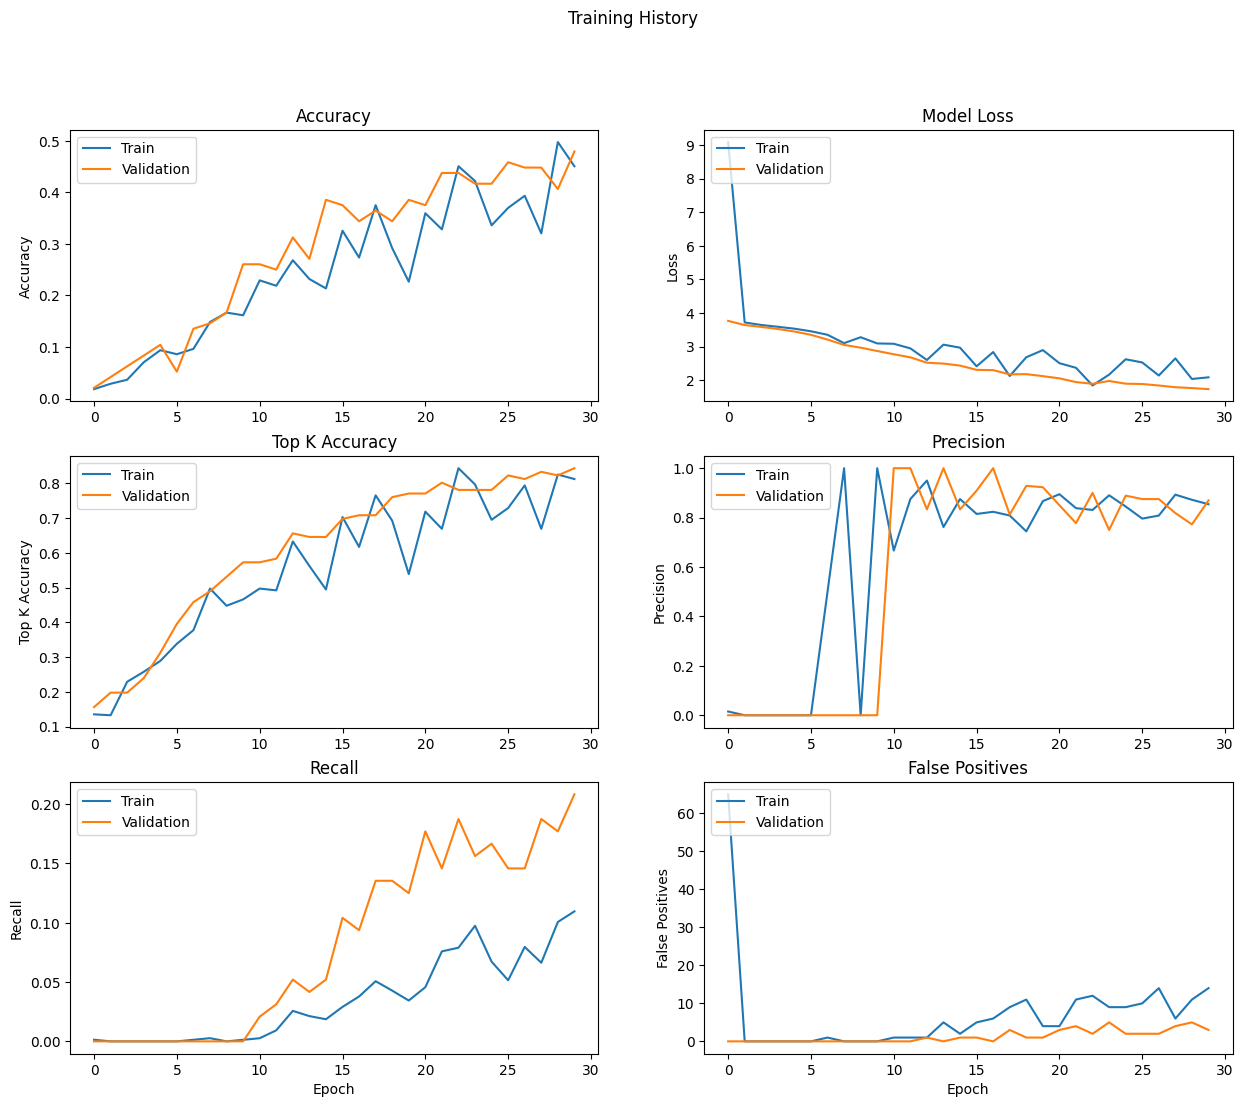

In [ ]:
# Plot and visualise learning curves
plot_training_history(mobilenet_multi_4_history)

### 5.1.2 Unfreeze Last 11 Layers (including 1 full block)

In [ ]:
# Check number of layers in the base model
print("Number of layers in the base model: ", len(mobilenet_base_model.layers))

Number of layers in the base model:  154


In [ ]:
# Check number of layers in the fusion model
print("Number of layers in the fusion model: ", len(mobilenet_multi_4.layers))

Number of layers in the fusion model:  15


In [ ]:
# View MobileNet base model layers
mobilenet_multi_4_layers = [(layer, layer.name, layer.trainable) \
                           for layer in mobilenet_multi_4.get_layer('mobilenetv2_1.00_224').layers]

mobilenet_layer_df = pd.DataFrame(mobilenet_multi_4_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
# Check if layers match to ensure credibility of unfreezing phase
len(mobilenet_layer_df) == len(mobilenet_base_model.layers)

True

In [ ]:
# Assign to new variable
mobilenet_multi_4_tune = mobilenet_multi_4
# View summary of fusion model with frozen layers
mobilenet_multi_4_tune.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 coloured_image (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['coloured_image[0][0]']         
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['lambda[0][0]']                 
 al)                                                                                              
                                                                                            

In [ ]:
# Get and view names of layers in last block
last_block = mobilenet_layer_df[mobilenet_layer_df['Layer Name'].str.contains('16')]['Layer Type'].values.tolist() + mobilenet_layer_df.tail(3)['Layer Type'].values.tolist()

last_block

In [ ]:
# Freeze all the layers before the last 11 layers
for layer in mobilenet_multi_4_tune.get_layer('mobilenetv2_1.00_224').layers[-11:]:
  layer.trainable = True

In [ ]:
# Check that correct layers have been unfrozen
for layer in mobilenet_multi_4_tune.get_layer('mobilenetv2_1.00_224').layers:
  if layer.trainable == True:
    print(layer.name)

block_16_expand
block_16_expand_BN
block_16_expand_relu
block_16_depthwise
block_16_depthwise_BN
block_16_depthwise_relu
block_16_project
block_16_project_BN
Conv_1
Conv_1_bn
out_relu


### 5.1.3 Compile Model with a Lower Learning Rate

In [ ]:
print(f"MobileNetV2's current LR: {tf.keras.backend.get_value(mobilenet_multi_4_tune.optimizer.lr)}")

MobileNetV2's current LR: 0.0010000000474974513


In [ ]:
# Compile model again with adjusted learning rate
mobilenet_multi_4_tune = compile_model(mobilenet_multi_4_tune, optimizer=Adam(learning_rate=1e-5))

In [ ]:
print(f"MobileNetV2's newly-adjusted LR: {tf.keras.backend.get_value(mobilenet_multi_4_tune.optimizer.lr)}")

MobileNetV2's newly-adjusted LR: 9.999999747378752e-06


### Continue Training Model with Unfrozen Layers

In [ ]:
# initial epochs was 30 --> increase to 80 total epochs by adding 50
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

mobilenet_multi_4_tune_history, mobilenet_multi_4_tune, mobilenet_multi_4_tune_elapsed_time = train_fusion_model(
    mobilenet_multi_4_tune, model_name,
    train_gen=custom_train_datagen,
    val_gen=custom_val_datagen,
    class_weights=class_weights,
    result_dir=PP_MULTI_RESULT_DIR,
    log_dir=PP_MULTI_TB_DIR,
    additional_callbacks=add_callbacks(5),
    epochs=total_epochs,
    workers=4,
    use_multiprocessing=True,
    version='v4_tune_11',
    batch_size=BATCH_SIZE)

In [ ]:
plot_training_history(mobilenet_multi_4_tune_history)

## 5.2 ResNet: Unfreezing the Last Blocks



### 5.2.1 Build and Compile Model

In [ ]:
# # Clear existing session if needed
# tf.keras.backend.clear_session()

In [ ]:
model_name = 'ResNet50_Multi'

# Load ResNet50 V2 with ImageNet weights without last fully connected layers
resnet50_base_model = ResNet50V2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                      weights='imagenet',
                                      include_top=False)

resnet50_multi_4 = tf.keras.saving.load_model(os.path.join(PP_MULTI_RESULT_DIR,
                                                                  'ResNet50_Multi/ResNet50_Multi_v3'))
resnet50_multi_4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 coloured_image (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['coloured_image[0][0]']         
                                                                                                  
 resnet50v2 (Functional)        (None, 7, 7, 2048)   23564800    ['lambda[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50v2[0][0]']       

In [ ]:
# Compile model
resnet50_multi_4_tune = resnet50_multi_4
resnet50_multi_4_tune = compile_model(resnet50_multi_4_tune, optimizer=Adam())

### 5.2.2 Unfreeze Last Convolution Blocks

In [ ]:
# View MobileNet base model layers
resnet50_multi_4_tune_layers = [(layer, layer.name, layer.trainable) \
                           for layer in resnet50_multi_4_tune.get_layer('resnet50v2').layers]

resnet50_multi_4_tune_layer_df = pd.DataFrame(resnet50_multi_4_tune_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
len(resnet50_multi_4_tune_layer_df) == len(resnet50_base_model.layers)

True

In [ ]:
resnet50_multi_4_tune_layer_df[154:]

,Layer Type,Layer Name,Layer Trainable
154,<keras.layers.normalization.batch_normalizatio...,conv5_block1_preact_bn,False
155,<keras.layers.core.activation.Activation objec...,conv5_block1_preact_relu,False
156,<keras.layers.convolutional.conv2d.Conv2D obje...,conv5_block1_1_conv,False
157,<keras.layers.normalization.batch_normalizatio...,conv5_block1_1_bn,False
158,<keras.layers.core.activation.Activation objec...,conv5_block1_1_relu,False
159,<keras.layers.reshaping.zero_padding2d.ZeroPad...,conv5_block1_2_pad,False
160,<keras.layers.convolutional.conv2d.Conv2D obje...,conv5_block1_2_conv,False
161,<keras.layers.normalization.batch_normalizatio...,conv5_block1_2_bn,False
162,<keras.layers.core.activation.Activation objec...,conv5_block1_2_relu,False
163,<keras.layers.convolutional.conv2d.Conv2D obje...,conv5_block1_0_conv,False


In [ ]:
for layer in resnet50_multi_4_tune.get_layer('resnet50v2').layers[154:]:
   print(layer.name)

conv5_block1_preact_bn
conv5_block1_preact_relu
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_pad
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_out
conv5_block2_preact_bn
conv5_block2_preact_relu
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_pad
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_out
conv5_block3_preact_bn
conv5_block3_preact_relu
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [ ]:
# Unfreeze last blocks of the base model
for layer in resnet50_multi_4_tune.get_layer('resnet50v2').layers[:154]:
   layer.trainable = False
for layer in resnet50_multi_4_tune.get_layer('resnet50v2').layers[154:]:
   layer.trainable = True

In [ ]:
resnet50_multi_4_tune.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 coloured_image (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['coloured_image[0][0]']         
                                                                                                  
 resnet50v2 (Functional)        (None, 7, 7, 2048)   23564800    ['lambda[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50v2[0][0]']       

### 5.2.3 Compile Model with a Lower Learning Rate

In [ ]:
print(f"MobileNetV2's current LR: {tf.keras.backend.get_value(resnet50_multi_4_tune.optimizer.lr)}")

MobileNetV2's current LR: 0.0010000000474974513


In [ ]:
# Compile model again with adjusted learning rate
resnet50_multi_4_tune = compile_model(resnet50_multi_4_tune, optimizer=Adam(learning_rate=1e-5))

In [ ]:
print(f"MobileNetV2's newly-adjusted LR: {tf.keras.backend.get_value(resnet50_multi_4_tune.optimizer.lr)}")

MobileNetV2's newly-adjusted LR: 9.999999747378752e-06


### 5.2.4 Continue Training Model with Unfrozen Layers

In [ ]:
resnet50_multi_4_tune_history, resnet50_multi_4_tune, resnet50_multi_4_tune_elapsed_time = train_fusion_model(
    resnet50_multi_4_tune, model_name,
    train_gen=custom_train_datagen,
    val_gen=custom_val_datagen,
    class_weights=class_weights,
    result_dir=PP_MULTI_RESULT_DIR,
    log_dir=PP_MULTI_TB_DIR,
    additional_callbacks=add_callbacks(5),
    epochs=50,
    workers=4,
    use_multiprocessing=True,
    version='v4_tune_11',
    batch_size=BATCH_SIZE)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.7780 - accuracy: 0.5000 - top_k_categorical_accuracy: 0.8802 - precision: 0.7800 - recall: 0.1548 - false_positives: 33.0000
Epoch 1: val_loss improved from inf to 1.37943, saving model to /content/drive/MyDrive/uploaded_datasets/pill-classification/all-results/multi-results-pp/ResNet50_Multi/ResNet50_Multi_v4_tune_11


12/12 [==============================] - 75s 6s/step - loss: 1.7780 - accuracy: 0.5000 - top_k_categorical_accuracy: 0.8802 - precision: 0.7800 - recall: 0.1548 - false_positives: 33.0000 - val_loss: 1.3794 - val_accuracy: 0.5312 - val_top_k_categorical_accuracy: 0.9062 - val_precision: 0.7391 - val_recall: 0.3542 - val_false_positives: 12.0000 - lr: 1.0000e-05
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.6503 - accuracy: 0.5312 - top_k_categorical_accuracy: 0.8932 - precision: 0.8304 - recall: 0.1919 - false_positives: 29.0000
Epoch 2: val_loss did not improve from 1.37943
12/12 [==============================] - 38s 3s/step - loss: 1.6503 - accuracy: 0.5312 - top_k_categorical_accuracy: 0.8932 - precision: 0.8304 - recall: 0.1919 - false_positives: 29.0000 - val_loss: 1.3796 - val_accuracy: 0.5312 - val_top_k_categorical_accuracy: 0.9062 - val_precision: 0.7391 - val_recall: 0.3542 - val_false_positives: 12.0000 - lr: 1.0000e-05
Epoch 3/50
12/12 [============

In [ ]:
print(f'elapsed_time: {resnet50_multi_4_tune_elapsed_time}')

elapsed_time: 263.3371688299994


In [ ]:
plot_training_history(resnet50_multi_4_tune_history)

# (6) Evaluation: Final Implementation

In [ ]:
def compare_results(model_names, result_array):
  print("Model Performance\n")

  for model_name, results in zip(model_names, result_array):
    print("======================== {} ========================".format(model_name))
    print(pd.DataFrame(results.items(), columns=['metric', 'score']), "\n\n")

## 6.1 Baseline Performance

In [ ]:
# Create dataframe for flow of image data
test_df = pd.DataFrame({
    'colour_filepath': test_data_dict.keys(),
    'y_ohe': test_data_dict.values()
})
test_df['y_ohe'] = test_df['y_ohe'].astype(str)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   colour_filepath  56 non-null     object
 1   y_ohe            56 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB


In [ ]:
# TEST
base_test_datagen = ImageDataGenerator(rescale=1./255)
base_test_generator = base_test_datagen.flow_from_dataframe(
  test_df,
  x_col='colour_filepath',
  y_col='y_ohe',
  shuffle=False,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=len(test_data_dict.values()),
  class_mode='categorical'
)

Found 56 validated image filenames belonging to 40 classes.


In [ ]:
baseline_eval_results = baseline_cnn_model.evaluate(base_test_generator, return_dict=True, verbose=1)

1/1 [==============================] - 1s 1s/step - loss: 8.1163 - accuracy: 0.0357 - top_k_categorical_accuracy: 0.1786 - precision: 0.0385 - recall: 0.0179 - false_positives: 25.0000


In [ ]:
# Get and view names of evaluation metrics previously set
evaluation_metrics = baseline_cnn_model.metrics_names
print(evaluation_metrics)

['loss', 'accuracy', 'top_k_categorical_accuracy', 'precision', 'recall', 'false_positives']


## 6.2 Comparison of Backbone Model Performance

### 6.2.1 Multi-Data generator for test set

In [ ]:
# Initialise custom data generator on full test set
custom_test_datagen = CustomDataGenerator(data_dict=test_data_dict,
                                          batch_size=len(test_data_dict.values()),
                                          is_train=False, is_augment=False, is_shuffle=False)

Found 56 images belonging to 40 classes


### 6.2.2 MobileNet vs. ResNet-50 Multi-Input Transfer Learning Models

This takes into account the multi-input model (from Section 3)

In [ ]:
# Obtain evaluation metrics of respective models
mobilenet_eval_results_4 = mobilenet_multi_4.evaluate(custom_test_datagen, return_dict=True, verbose=1)
resnet50_eval_results_4 = resnet50_multi_4.evaluate(custom_test_datagen, return_dict=True, verbose=1)

1/1 [==============================] - 7s 7s/step - loss: 1.2199 - accuracy: 0.5357 - top_k_categorical_accuracy: 0.9821 - precision: 0.7407 - recall: 0.3571 - false_positives: 7.0000


In [ ]:
# Print comparison summary
compare_results(['MobileNet', 'ResNet50'],
 [mobilenet_eval_results_4, resnet50_eval_results_4])

Model Performance

======================== MobileNet ========================
                       metric     score
0                        loss  1.292938
1                    accuracy  0.500000
2  top_k_categorical_accuracy  0.910714
3                   precision  0.900000
4                      recall  0.321429
5             false_positives  2.000000 


======================== ResNet50 ========================
                       metric     score
0                        loss  1.219869
1                    accuracy  0.535714
2  top_k_categorical_accuracy  0.982143
3                   precision  0.740741
4                      recall  0.357143
5             false_positives  7.000000 




### 6.2.3 Comparison: Un-tuned vs. Fine-tuned

This takes into account the fusion model with the winning transfer learning backbone model.

In this case, it is based on the MobileNet and ResNet-50 fusion models with:
1. Entirely frozen layers
2. Fine-tuned by unfreezing selected layers

#### MobileNet

In [ ]:
mobilenet_eval_results_4 = mobilenet_multi_4.evaluate(custom_test_datagen, return_dict=True, verbose=1)
mobilenet_multi_finetuned_results = mobilenet_multi_4_tune.evaluate(custom_test_datagen, return_dict=True, verbose=1)

1/1 [==============================] - 7s 7s/step - loss: 1.5177 - accuracy: 0.5357 - top_k_categorical_accuracy: 0.9107 - precision: 0.9375 - recall: 0.2679 - false_positives: 1.0000


In [ ]:
# Print comparison summary
compare_results(['MobileNet', 'MobileNet (Fine-tuned)'],
 [mobilenet_eval_results_4, mobilenet_multi_finetuned_results])

Model Performance

======================== MobileNet ========================
                       metric     score
0                        loss  1.596390
1                    accuracy  0.500000
2  top_k_categorical_accuracy  0.875000
3                   precision  0.888889
4                      recall  0.285714
5             false_positives  2.000000 


======================== MobileNet (Fine-tuned) ========================
                       metric     score
0                        loss  1.517672
1                    accuracy  0.535714
2  top_k_categorical_accuracy  0.910714
3                   precision  0.937500
4                      recall  0.267857
5             false_positives  1.000000 




#### ResNet-50

In [ ]:
resnet50_eval_results_4 = resnet50_multi_4.evaluate(custom_test_datagen, return_dict=True, verbose=1)
resnet50_multi_finetuned_results = resnet50_multi_4_tune.evaluate(custom_test_datagen, return_dict=True, verbose=1)

1/1 [==============================] - 23s 23s/step - loss: 1.3637 - accuracy: 0.5357 - top_k_categorical_accuracy: 0.9464 - precision: 0.7826 - recall: 0.3214 - false_positives: 5.0000


1/1 [==============================] - 19s 19s/step - loss: 1.2166 - accuracy: 0.5357 - top_k_categorical_accuracy: 0.9821 - precision: 0.7500 - recall: 0.3750 - false_positives: 7.0000


In [ ]:
# Print comparison summary
compare_results(['ResNet-50', 'ResNet-50 (Fine-tuned)'],
 [resnet50_eval_results_4, resnet50_multi_finetuned_results])

Model Performance

======================== ResNet-50 ========================
                       metric     score
0                        loss  1.363691
1                    accuracy  0.535714
2  top_k_categorical_accuracy  0.946429
3                   precision  0.782609
4                      recall  0.321429
5             false_positives  5.000000 


======================== ResNet-50 (Fine-tuned) ========================
                       metric     score
0                        loss  1.216567
1                    accuracy  0.535714
2  top_k_categorical_accuracy  0.982143
3                   precision  0.750000
4                      recall  0.375000
5             false_positives  7.000000 




## 6.3 Overall Evaluation: Baseline vs. New Models

In [ ]:
# Create dataframe to view summary of results
df_eval_results = pd.DataFrame.from_dict({
    'Baseline_CNN': baseline_eval_results,
    'MobileNet_Fusion_Untuned': mobilenet_eval_results_4,
    'MobileNet_Fusion_Finetuned': mobilenet_multi_finetuned_results,
    'ResNet_Fusion_Untuned': resnet50_eval_results_4,
    'ResNet_Fusion_Finetuned': resnet50_multi_finetuned_results
  }, orient='index')

df_eval_results

,loss,accuracy,top_k_categorical_accuracy,precision,recall,false_positives
Baseline_CNN,8.116315,0.035714,0.178571,0.038462,0.017857,25.0
MobileNet_Fusion_Untuned,1.596390,0.500000,0.875000,0.888889,0.285714,2.0
MobileNet_Fusion_Finetuned,1.517671,0.535714,0.910714,0.937500,0.267857,1.0
ResNet_Fusion_Untuned,1.363691,0.535714,0.946429,0.782609,0.321429,5.0
ResNet_Fusion_Finetuned,1.216567,0.535714,0.982143,0.750000,0.375000,7.0


In [ ]:
# Plot to compare and visualise accuracy scores across full dataset
fig = px.bar(df_eval_results,
             x=df_eval_results.index,
             y=["accuracy", "top_k_categorical_accuracy"],
             orientation = "v",
             barmode = 'group',
             title='Top-1 and Top-5 Accuracy Scores across Different Models',)
fig.show()

In [ ]:
# Plot to compare and visualise false_positives across full dataset
fig = px.bar(df_eval_results,
             x=df_eval_results.index,
             y="false_positives",
             orientation = "v",
             barmode = 'group',
             title='False Positives across Different Models')
fig.show()

Although the fine-tuned ResNet-50 Fusion Model saw higher accuracy scores compared to the fine-tuned MobileNet Fusion Model, its false positives were measurably higher than that of the latter. Therefore, the fine-tuned MobileNet Fusion Model emerges as the winner of this implementation to ensure a less drastic gap between top-1 and top-k categortical accuracy scores, as well as false positives. We further determine the success of the final implementation with a significantly higher top-5 categorical accuracy score of 0.91, comapred to 0.18 obtained in the baseline single-input CNN model built from scratch.

In the following section, we can observe higher top-1 accuracy score on an unseen image when prediction was performed with the ResNet-50 model. However, it did not offer adequate performance to a second image. This could bea attributed to lower generalisation ability, where the dataset did not contain sufficient samples that allowed the learning of the particular class.

## 6.4 Predictions with Top-contenders

### Overview
To predict with a real-life image (consumer) taken under unconstrained imaging conditions, we will first require a custom pipeline to apply pre-processing methods.


*   `predict_image`: Applies colour-enhancement techniques and extracts HOG-LBP feature vector to feed into the model for prediction.
*   `load_model`: Loads model from input path to folder containing model

### Functions

In [ ]:
def predict_image(model,
                  image_path,
                  image_size=IMAGE_SIZE,
                  clip_limit=3.0,
                  tile_grid_size=(5, 5),
                  top_k=40):

  #Instantiate class instance
  colour_preprocessor = ColourPreprocessor(target_size=image_size,
                                           clip_limit=clip_limit,
                                           tile_grid_size=tile_grid_size)

  #Instantiate class instance
  texture_extractor = TextureDescriptor(target_size=image_size)

  # Read image
  input_img = cv2.imread(image_path)
  # Preprocess image for colour
  colour_img = colour_preprocessor.image_generator(input_img)
  # Get array for extracted shape-texture features
  feature_vector = texture_extractor.get_combined_features(input_img)

  # Add dimension to match input shapes
  reshaped_img = np.expand_dims(colour_img, axis=0)
  reshaped_feature_vector = np.expand_dims(feature_vector, axis=0)

  # Predict by classes
  prediction = model.predict([reshaped_img, reshaped_feature_vector])
  top_k_values, top_k_indices = tf.nn.top_k(prediction, top_k)

  # Source: https://saturncloud.io/blog/how-to-get-topk-predictions-from-tensorflow/
  # Returns top k predictions
  return {
      CLASSES[top_k_indices[0][i]]: top_k_values.numpy()[0][i] for i in range(top_k)
      }


def load_fusion_model(model_path, lambda_obj):
  """
  Loads model from desired path
  """
  model = tf.keras.models.load_model(os.path.join(PP_MULTI_RESULT_DIR, model_path), custom_objects={
          'accuracy': tf.keras.metrics.CategoricalAccuracy,
          'top_k_categorical_accuracy': tf.keras.metrics.TopKCategoricalAccuracy,
          'precision': tf.keras.metrics.Precision,
          'recall': tf.keras.metrics.Recall,
          'false_positives': tf.keras.metrics.FalsePositives,
          'lambda': lambda_obj
  })

  return model

In [ ]:
def plot_predicted_images(n_plot, predictions, input_image, actual_label, model_name):
  top_labels = list(predictions.keys())[:n_plot]

  # Plot reference images of predicted labels in subplots
  fig, axs = plt.subplots(nrows=1, ncols=n_plot+1, figsize=(14, 4))
  for i, ax in enumerate(axs.flatten()):
    # Get filepath to reference image
    img = data_df[(data_df['ndc9'] == top_labels[i-1]) & (data_df['is_ref'] == True) & (data_df['is_front'] == True)].filepath.values[0]
    plt.sca(ax)
    plt.axis('off')
    # Plot input test image
    if i == 0:
      plt.imshow(cv2.imread(input_image))
      plt.title(f'Input Image: {actual_label[0]}')
    # Plot top predicted images
    else:
      plt.imshow(cv2.imread(img))
      plt.title(f'Prediction {i}: {top_labels[i-1]}')


  plt.tight_layout()
  plt.suptitle(f'Top {n_plot} Predictions by {model_name}')
  plt.show()

### 6.4.1 Assign image to predict

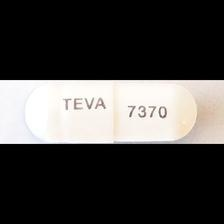

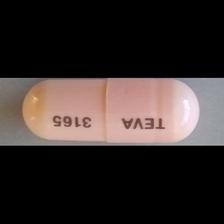

In [ ]:
input_img_1 = '/content/drive/MyDrive/uploaded_datasets/pill-recognition/combined_dataset/split_dataset/000937370/4640.jpg'
input_img_2 = '/content/drive/MyDrive/uploaded_datasets/pill-recognition/combined_dataset/split_dataset/000933165/2103.jpg'

cv2_imshow(cv2.imread(input_img_1))
cv2_imshow(cv2.imread(input_img_2))

In [ ]:
# Get and print actual class of pill in image
actual_label_1 = directory_df[directory_df['filename'] == input_img_1.split('/')[-1]].ndc9.values
actual_label_2 = directory_df[directory_df['filename'] == input_img_2.split('/')[-1]].ndc9.values

print(actual_label_1)
print(actual_label_2)

['937370']
['933165']


### 6.4.2 Load Models

In [ ]:
# Load mobilenet model
mobilenet_model = load_fusion_model('MobileNet_Multi/MobileNet_Multi_v4_tune_11',
                                    tf.keras.applications.mobilenet_v2.preprocess_input)

# Load resnet-50 model
resnet50_model = load_fusion_model('ResNet50_Multi/ResNet50_Multi_v4_tune_11',
                                    tf.keras.applications.resnet_v2.preprocess_input)

### 6.3.3 Predict on Input Image 1

In [ ]:
# Get predictions for mobilenet model
mobilenet_preds = predict_image(mobilenet_model, input_img_1)
# Print position of true label in predictions
print("[MobileNet] Position of true label in predictions:", list(mobilenet_preds.keys()).index(actual_label_1)+1)

# Get predictions for resnet-50 model
resnet50_preds = predict_image(resnet50_model, input_img_1)
# Print position of true label in predictions
print("[ResNet-50] Position of true label in predictions:", list(resnet50_preds.keys()).index(actual_label_1)+1)

1/1 [==============================] - 1s 1s/step
[MobileNet] Position of true label in predictions: 1
1/1 [==============================] - 1s 1s/step
[ResNet-50] Position of true label in predictions: 1


In [ ]:
# Print top 5 predictions with highest accuracy score for mobilenet model
print('[MobileNet] Top 5 predictions')
pprint(list(mobilenet_preds.items())[:5])

print()

# Print top 5 predictions with highest accuracy score for resnet-50 model
print('[ResNet-50] Top 5 predictions')
pprint(list(resnet50_preds.items())[:5])

[MobileNet] Top 5 predictions
[('937370', 0.5865987),
 ('933165', 0.2181557),
 ('931063', 0.12717217),
 ('931060', 0.014122653),
 ('930135', 0.012669773)]

[ResNet-50] Top 5 predictions
[('937370', 0.3639337),
 ('1724280', 0.23321418),
 ('931063', 0.14411555),
 ('930135', 0.09506063),
 ('933165', 0.075621486)]


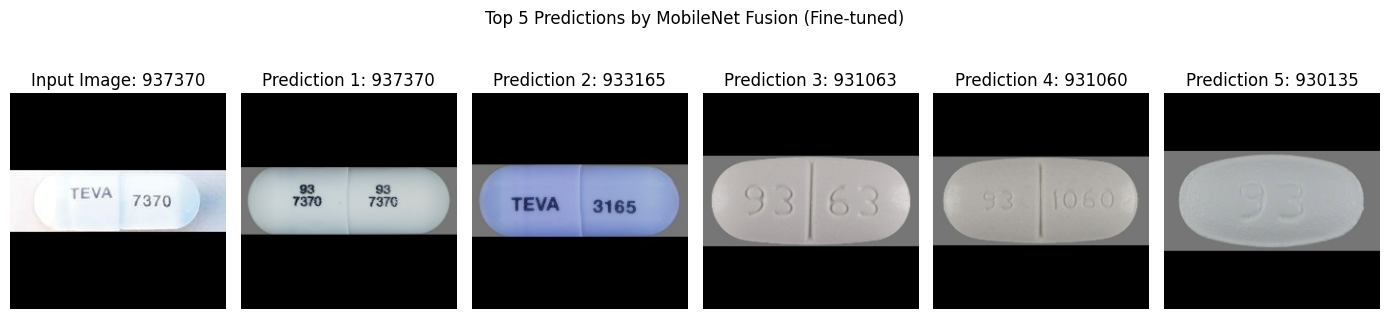

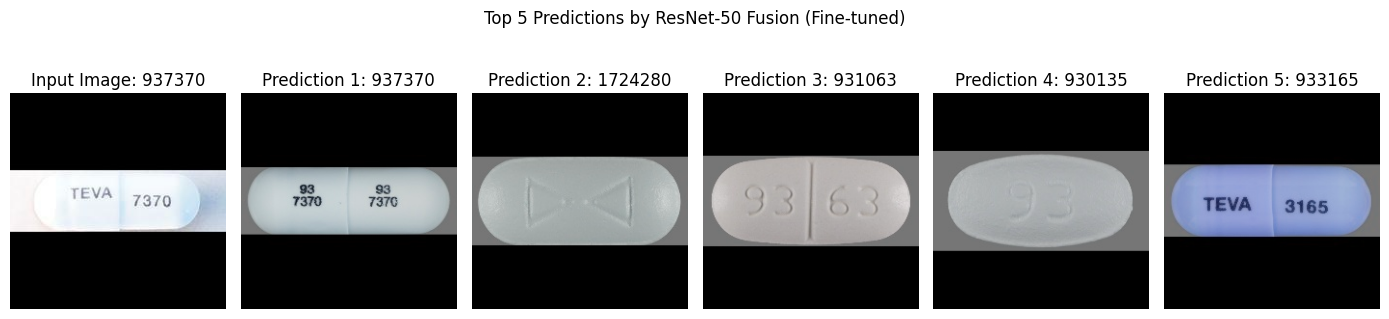

In [ ]:
#  Plot MobileNet predicted images
plot_predicted_images(5, mobilenet_preds,
                      input_img_1, actual_label_1,
                      'MobileNet Fusion (Fine-tuned)')

#  Plot ResNet-50 predicted images
plot_predicted_images(5, resnet50_preds,
                      input_img_1, actual_label_1,
                      'ResNet-50 Fusion (Fine-tuned)')

### 6.3.3 Predict on Input Image 2

In [ ]:
# Get predictions for mobilenet model
mobilenet_preds_2 = predict_image(mobilenet_model, input_img_2)
# Print position of true label in predictions
print("[MobileNet] Position of true label in predictions:", list(mobilenet_preds_2.keys()).index(actual_label_2)+1)

# Get predictions for resnet-50 model
resnet50_preds_2 = predict_image(resnet50_model, input_img_2)
# Print position of true label in predictions
print("[ResNet-50] Position of true label in predictions:", list(resnet50_preds_2.keys()).index(actual_label_2)+1)

1/1 [==============================] - 0s 211ms/step
[MobileNet] Position of true label in predictions: 1
1/1 [==============================] - 0s 459ms/step
[ResNet-50] Position of true label in predictions: 1


In [ ]:
# Print top 5 predictions with highest accuracy score for mobilenet model
print('[MobileNet] Top 5 predictions')
pprint(list(mobilenet_preds_2.items())[:5])

print()

# Print top 5 predictions with highest accuracy score for resnet-50 model
print('[ResNet-50] Top 5 predictions')
pprint(list(resnet50_preds_2.items())[:5])

[MobileNet] Top 5 predictions
[('933165', 0.7620342),
 ('937370', 0.15169413),
 ('931063', 0.0209006),
 ('933147', 0.019405259),
 ('930149', 0.011467089)]

[ResNet-50] Top 5 predictions
[('933165', 0.6502602),
 ('930149', 0.1346606),
 ('933171', 0.07603621),
 ('937370', 0.06762984),
 ('933147', 0.038463205)]


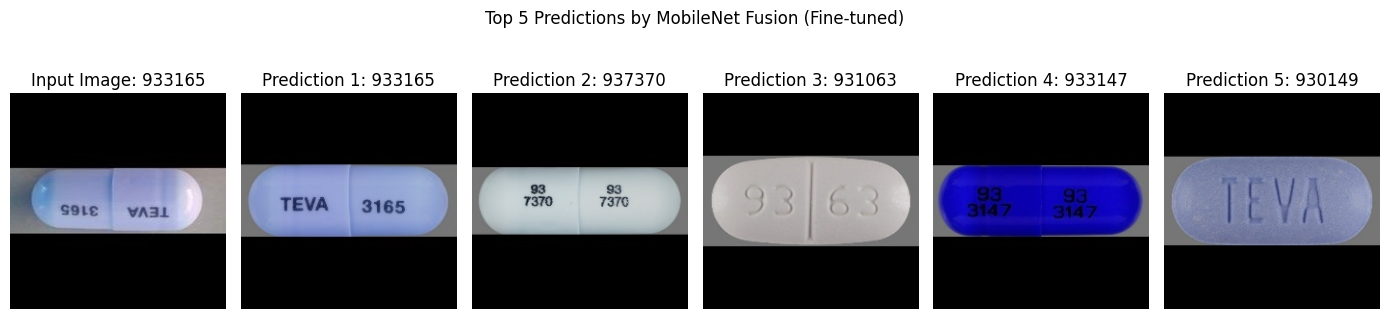

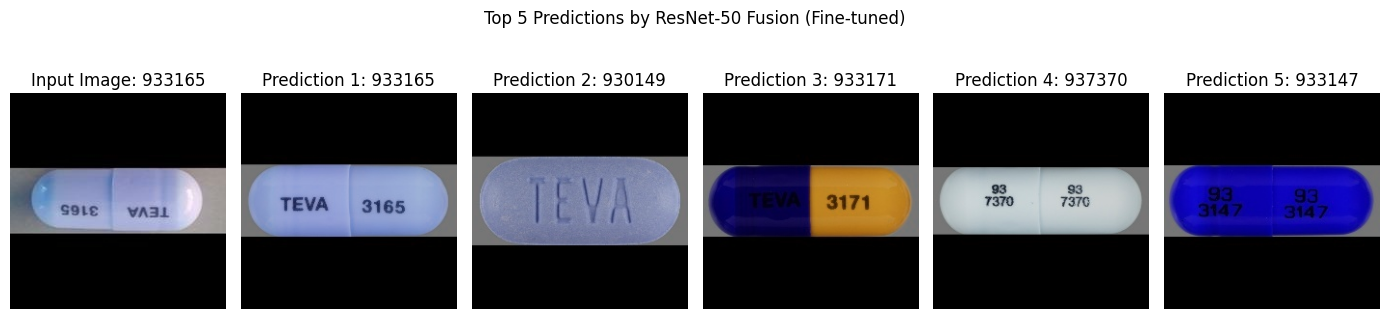

In [ ]:
#  Plot MobileNet predicted images
plot_predicted_images(5, mobilenet_preds_2,
                      input_img_2, actual_label_2,
                      'MobileNet Fusion (Fine-tuned)')

#  Plot ResNet-50 predicted images
plot_predicted_images(5, resnet50_preds_2,
                      input_img_2, actual_label_2,
                      'ResNet-50 Fusion (Fine-tuned)')

# (Optional) Convert to TFLite For Potential App Development on Local Machine

In [ ]:
mobilenet_converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_model)
tflite_mobilenet = mobilenet_converter.convert()

with open('/content/mobilenet.tflite', 'wb') as f:
  f.write(tflite_mobilenet)